In [1]:
import numpy as np
from numpy import dot
import pandas as pd
import matplotlib.pyplot as plt
import warnings

import scipy as sp
from scipy import stats as st
from scipy.stats import norm

import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn import preprocessing as skp

import nltk
import re
from gensim.models import Word2Vec
from nltk import FreqDist, word_tokenize
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import cosine_similarity
#tqdm


In [145]:
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [2]:
stop_words = set(stopwords.words('english'))

## Import Data

In [92]:
#train_stances.random = pd.read_csv('train_stances.csv')
train_stances = pd.read_csv('train_stances.csv')
train_bodies = pd.read_csv('train_bodies.csv')
#test_stances_unlabeled = pd.read_csv('test_stances_unlabeled.csv')
#test_bodies = pd.read_csv('test_bodies.csv')
comp_test_stances = pd.read_csv('competition_test_stances.csv')
#comp_test_stances_unlabeled = pd.read_csv('competition_test_stances_unlabeled.csv')
comp_test_bodies = pd.read_csv('competition_test_bodies.csv')

In [191]:
print('train_stances: ',train_stances.shape)
train_stances.head(5)

train_stances:  (49972, 3)


,Headline,Body ID,Stance
0,Police find mass graves with at least '15 bodi...,712,unrelated
1,Hundreds of Palestinians flee floods in Gaza a...,158,agree
2,"Christian Bale passes on role of Steve Jobs, a...",137,unrelated
3,HBO and Apple in Talks for $15/Month Apple TV ...,1034,unrelated
4,Spider burrowed through tourist's stomach and ...,1923,disagree


In [192]:
print('train_bodies: ',train_bodies.shape)
train_bodies.head(5)

train_bodies:  (1683, 2)


,Body ID,articleBody
0,0,A small meteorite crashed into a wooded area i...
1,4,Last week we hinted at what was to come as Ebo...
2,5,(NEWSER) – Wonder how long a Quarter Pounder w...
3,6,"Posting photos of a gun-toting child online, I..."
4,7,At least 25 suspected Boko Haram insurgents we...


In [95]:
print(comp_test_stances.shape)
comp_test_stances.head(5)

(25413, 3)


,Headline,Body ID,Stance
0,Ferguson riots: Pregnant woman loses eye after...,2008,unrelated
1,Crazy Conservatives Are Sure a Gitmo Detainee ...,1550,unrelated
2,A Russian Guy Says His Justin Bieber Ringtone ...,2,unrelated
3,"Zombie Cat: Buried Kitty Believed Dead, Meows ...",1793,unrelated
4,Argentina's President Adopts Boy to End Werewo...,37,unrelated


In [194]:
print(comp_test_bodies.shape)
comp_test_bodies.head(5)

(904, 2)


,Body ID,articleBody
0,1,Al-Sisi has denied Israeli reports stating tha...
1,2,A bereaved Afghan mother took revenge on the T...
2,3,CNBC is reporting Tesla has chosen Nevada as t...
3,12,A 4-inch version of the iPhone 6 is said to be...
4,19,GR editor’s Note\n\nThere are no reports in th...


In [97]:
test_head_body = pd.merge(comp_test_stances, comp_test_bodies, how='left', left_on = 'Body ID',right_on='Body ID',copy=True)
test_head_body.head(5)

,Headline,Body ID,Stance,articleBody
0,Ferguson riots: Pregnant woman loses eye after...,2008,unrelated,A RESPECTED senior French police officer inves...
1,Crazy Conservatives Are Sure a Gitmo Detainee ...,1550,unrelated,Dave Morin's social networking company Path is...
2,A Russian Guy Says His Justin Bieber Ringtone ...,2,unrelated,A bereaved Afghan mother took revenge on the T...
3,"Zombie Cat: Buried Kitty Believed Dead, Meows ...",1793,unrelated,Hewlett-Packard is officially splitting in two...
4,Argentina's President Adopts Boy to End Werewo...,37,unrelated,An airline passenger headed to Dallas was remo...


In [98]:
test_head_body.shape

(25413, 4)

In [102]:
test_all = pd.merge(test_head_body,stance,left_on='Stance', right_on='Stance', how='left')
test_all.head(5)

,Headline,Body ID,Stance,articleBody,S
0,Ferguson riots: Pregnant woman loses eye after...,2008,unrelated,A RESPECTED senior French police officer inves...,4.0
1,Crazy Conservatives Are Sure a Gitmo Detainee ...,1550,unrelated,Dave Morin's social networking company Path is...,4.0
2,A Russian Guy Says His Justin Bieber Ringtone ...,2,unrelated,A bereaved Afghan mother took revenge on the T...,4.0
3,"Zombie Cat: Buried Kitty Believed Dead, Meows ...",1793,unrelated,Hewlett-Packard is officially splitting in two...,4.0
4,Argentina's President Adopts Boy to End Werewo...,37,unrelated,An airline passenger headed to Dallas was remo...,4.0


In [198]:
train_head_body = pd.merge(train_stances, train_bodies, how='left', left_on = 'Body ID',right_on='Body ID',copy=True)
train_head_body.head(5)

,Headline,Body ID,Stance,articleBody
0,Police find mass graves with at least '15 bodi...,712,unrelated,Danny Boyle is directing the untitled film\n\n...
1,Hundreds of Palestinians flee floods in Gaza a...,158,agree,Hundreds of Palestinians were evacuated from t...
2,"Christian Bale passes on role of Steve Jobs, a...",137,unrelated,30-year-old Moscow resident was hospitalized w...
3,HBO and Apple in Talks for $15/Month Apple TV ...,1034,unrelated,(Reuters) - A Canadian soldier was shot at the...
4,Spider burrowed through tourist's stomach and ...,1923,disagree,"Fear not arachnophobes, the story of Bunbury's..."


## Split stances

In [200]:
train_agree = train_head_body[train_head_body['Stance']=='agree']
train_agree.shape

(3678, 4)

In [201]:
train_disagree = train_head_body[train_head_body['Stance']=='disagree']
train_disagree.shape

(840, 4)

In [202]:
train_discuss = train_head_body[train_head_body['Stance']=='discuss']
train_discuss.shape

(8909, 4)

In [203]:
train_unrelated = train_head_body[train_head_body['Stance']=='unrelated']
train_unrelated.shape

(36545, 4)

## Split train/ val set

In [204]:
#training set and validataion set are split in 1:9 ratio
agree_train, agree_val = train_test_split(train_agree, test_size=0.1)
disagree_train, disagree_val = train_test_split(train_disagree, test_size=0.1)
discuss_train, discuss_val = train_test_split(train_discuss, test_size=0.1)
unrelated_train, unrelated_val = train_test_split(train_unrelated, test_size=0.1)

In [205]:
#4 datasets were split separatedly then combined again to reserve the ratio of each class in training set and validatiaon set 
train_all = pd.concat([agree_train,disagree_train,discuss_train, unrelated_train],axis = 0)
val_all = pd.concat([agree_val,disagree_val,discuss_val,unrelated_val],axis = 0)

In [17]:
#head_min = train_all.head(5)
#train_min = head_min

## Data Cleaning Functions

In [104]:
def clean_head (df) :
    stop_words = set(stopwords.words('english'))
    df['Clean_Headline']=''
    clean = []
    for i in range(len(df)):
        head = df['Headline'].iloc[i]
        # split sentence into word tokens
        head_tokens = word_tokenize(head)
        # filter only english words
        head_eng = []
        for j in head_tokens:
            eng = re.sub("[^a-zA-Z]", " ",str(j))
            head_eng.append(eng)
        # convert all to lower case
        head_low = []
        for k in head_eng:
            lower = k.lower()
            head_low.append(lower)
        # convert plural to singlar
        head_sing = []
        for m in head_low:
            stemmer = nltk.PorterStemmer()
            sing = stemmer.stem(m)
            head_sing.append(sing)
        # remove stop words
        head_nstop = []
        for p in head_sing:
            if p not in stop_words:
                head_nstop.append(p)
        # save back to dataframe
        clean.append(head_nstop)
        print(i)
    df['Clean_headline']=clean

In [105]:
def clean_body (df) :
    stop_words = set(stopwords.words('english'))
    df['Clean_body']=''
    clean=[]
    for i in range(len(df)):
        body = df['articleBody'].iloc[i]
        # split sentence into word tokens
        body_tokens = word_tokenize(body)
        # filter only english words
        body_eng = []
        for j in body_tokens:
            eng = re.sub("[^a-zA-Z]", " ",str(j))
            body_eng.append(eng)
        # convert all to lower case
        body_low = []
        for k in body_eng:
            lower = k.lower()
            body_low.append(lower)
        # convert plural to singlar
        body_sing = []
        for m in body_low:
            stemmer = nltk.PorterStemmer()
            sing = stemmer.stem(m)
            body_sing.append(sing)
        # remove stop words
        body_nstop = []
        for p in body_sing:
            if p not in stop_words:
                body_nstop.append(p)
        # save back to dataframe
        clean.append(body_nstop)
        print(i)
    df['Clean_body'] = clean

In [108]:
clean_body(test_all)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063


3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3711
3712
3713
3714
3715
3716
3717
3718
3719
3720
3721


5181
5182
5183
5184
5185
5186
5187
5188
5189
5190
5191
5192
5193
5194
5195
5196
5197
5198
5199
5200
5201
5202
5203
5204
5205
5206
5207
5208
5209
5210
5211
5212
5213
5214
5215
5216
5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338
5339
5340
5341
5342
5343
5344
5345
5346
5347
5348
5349
5350
5351
5352
5353
5354
5355
5356
5357
5358
5359
5360
5361
5362
5363
5364
5365
5366
5367
5368
5369
5370
5371
5372
5373
5374
5375
5376
5377
5378
5379
5380


6821
6822
6823
6824
6825
6826
6827
6828
6829
6830
6831
6832
6833
6834
6835
6836
6837
6838
6839
6840
6841
6842
6843
6844
6845
6846
6847
6848
6849
6850
6851
6852
6853
6854
6855
6856
6857
6858
6859
6860
6861
6862
6863
6864
6865
6866
6867
6868
6869
6870
6871
6872
6873
6874
6875
6876
6877
6878
6879
6880
6881
6882
6883
6884
6885
6886
6887
6888
6889
6890
6891
6892
6893
6894
6895
6896
6897
6898
6899
6900
6901
6902
6903
6904
6905
6906
6907
6908
6909
6910
6911
6912
6913
6914
6915
6916
6917
6918
6919
6920
6921
6922
6923
6924
6925
6926
6927
6928
6929
6930
6931
6932
6933
6934
6935
6936
6937
6938
6939
6940
6941
6942
6943
6944
6945
6946
6947
6948
6949
6950
6951
6952
6953
6954
6955
6956
6957
6958
6959
6960
6961
6962
6963
6964
6965
6966
6967
6968
6969
6970
6971
6972
6973
6974
6975
6976
6977
6978
6979
6980
6981
6982
6983
6984
6985
6986
6987
6988
6989
6990
6991
6992
6993
6994
6995
6996
6997
6998
6999
7000
7001
7002
7003
7004
7005
7006
7007
7008
7009
7010
7011
7012
7013
7014
7015
7016
7017
7018
7019
7020


8462
8463
8464
8465
8466
8467
8468
8469
8470
8471
8472
8473
8474
8475
8476
8477
8478
8479
8480
8481
8482
8483
8484
8485
8486
8487
8488
8489
8490
8491
8492
8493
8494
8495
8496
8497
8498
8499
8500
8501
8502
8503
8504
8505
8506
8507
8508
8509
8510
8511
8512
8513
8514
8515
8516
8517
8518
8519
8520
8521
8522
8523
8524
8525
8526
8527
8528
8529
8530
8531
8532
8533
8534
8535
8536
8537
8538
8539
8540
8541
8542
8543
8544
8545
8546
8547
8548
8549
8550
8551
8552
8553
8554
8555
8556
8557
8558
8559
8560
8561
8562
8563
8564
8565
8566
8567
8568
8569
8570
8571
8572
8573
8574
8575
8576
8577
8578
8579
8580
8581
8582
8583
8584
8585
8586
8587
8588
8589
8590
8591
8592
8593
8594
8595
8596
8597
8598
8599
8600
8601
8602
8603
8604
8605
8606
8607
8608
8609
8610
8611
8612
8613
8614
8615
8616
8617
8618
8619
8620
8621
8622
8623
8624
8625
8626
8627
8628
8629
8630
8631
8632
8633
8634
8635
8636
8637
8638
8639
8640
8641
8642
8643
8644
8645
8646
8647
8648
8649
8650
8651
8652
8653
8654
8655
8656
8657
8658
8659
8660
8661


10088
10089
10090
10091
10092
10093
10094
10095
10096
10097
10098
10099
10100
10101
10102
10103
10104
10105
10106
10107
10108
10109
10110
10111
10112
10113
10114
10115
10116
10117
10118
10119
10120
10121
10122
10123
10124
10125
10126
10127
10128
10129
10130
10131
10132
10133
10134
10135
10136
10137
10138
10139
10140
10141
10142
10143
10144
10145
10146
10147
10148
10149
10150
10151
10152
10153
10154
10155
10156
10157
10158
10159
10160
10161
10162
10163
10164
10165
10166
10167
10168
10169
10170
10171
10172
10173
10174
10175
10176
10177
10178
10179
10180
10181
10182
10183
10184
10185
10186
10187
10188
10189
10190
10191
10192
10193
10194
10195
10196
10197
10198
10199
10200
10201
10202
10203
10204
10205
10206
10207
10208
10209
10210
10211
10212
10213
10214
10215
10216
10217
10218
10219
10220
10221
10222
10223
10224
10225
10226
10227
10228
10229
10230
10231
10232
10233
10234
10235
10236
10237
10238
10239
10240
10241
10242
10243
10244
10245
10246
10247
10248
10249
10250
10251
10252
10253
1025

11457
11458
11459
11460
11461
11462
11463
11464
11465
11466
11467
11468
11469
11470
11471
11472
11473
11474
11475
11476
11477
11478
11479
11480
11481
11482
11483
11484
11485
11486
11487
11488
11489
11490
11491
11492
11493
11494
11495
11496
11497
11498
11499
11500
11501
11502
11503
11504
11505
11506
11507
11508
11509
11510
11511
11512
11513
11514
11515
11516
11517
11518
11519
11520
11521
11522
11523
11524
11525
11526
11527
11528
11529
11530
11531
11532
11533
11534
11535
11536
11537
11538
11539
11540
11541
11542
11543
11544
11545
11546
11547
11548
11549
11550
11551
11552
11553
11554
11555
11556
11557
11558
11559
11560
11561
11562
11563
11564
11565
11566
11567
11568
11569
11570
11571
11572
11573
11574
11575
11576
11577
11578
11579
11580
11581
11582
11583
11584
11585
11586
11587
11588
11589
11590
11591
11592
11593
11594
11595
11596
11597
11598
11599
11600
11601
11602
11603
11604
11605
11606
11607
11608
11609
11610
11611
11612
11613
11614
11615
11616
11617
11618
11619
11620
11621
11622
1162

12825
12826
12827
12828
12829
12830
12831
12832
12833
12834
12835
12836
12837
12838
12839
12840
12841
12842
12843
12844
12845
12846
12847
12848
12849
12850
12851
12852
12853
12854
12855
12856
12857
12858
12859
12860
12861
12862
12863
12864
12865
12866
12867
12868
12869
12870
12871
12872
12873
12874
12875
12876
12877
12878
12879
12880
12881
12882
12883
12884
12885
12886
12887
12888
12889
12890
12891
12892
12893
12894
12895
12896
12897
12898
12899
12900
12901
12902
12903
12904
12905
12906
12907
12908
12909
12910
12911
12912
12913
12914
12915
12916
12917
12918
12919
12920
12921
12922
12923
12924
12925
12926
12927
12928
12929
12930
12931
12932
12933
12934
12935
12936
12937
12938
12939
12940
12941
12942
12943
12944
12945
12946
12947
12948
12949
12950
12951
12952
12953
12954
12955
12956
12957
12958
12959
12960
12961
12962
12963
12964
12965
12966
12967
12968
12969
12970
12971
12972
12973
12974
12975
12976
12977
12978
12979
12980
12981
12982
12983
12984
12985
12986
12987
12988
12989
12990
1299

14192
14193
14194
14195
14196
14197
14198
14199
14200
14201
14202
14203
14204
14205
14206
14207
14208
14209
14210
14211
14212
14213
14214
14215
14216
14217
14218
14219
14220
14221
14222
14223
14224
14225
14226
14227
14228
14229
14230
14231
14232
14233
14234
14235
14236
14237
14238
14239
14240
14241
14242
14243
14244
14245
14246
14247
14248
14249
14250
14251
14252
14253
14254
14255
14256
14257
14258
14259
14260
14261
14262
14263
14264
14265
14266
14267
14268
14269
14270
14271
14272
14273
14274
14275
14276
14277
14278
14279
14280
14281
14282
14283
14284
14285
14286
14287
14288
14289
14290
14291
14292
14293
14294
14295
14296
14297
14298
14299
14300
14301
14302
14303
14304
14305
14306
14307
14308
14309
14310
14311
14312
14313
14314
14315
14316
14317
14318
14319
14320
14321
14322
14323
14324
14325
14326
14327
14328
14329
14330
14331
14332
14333
14334
14335
14336
14337
14338
14339
14340
14341
14342
14343
14344
14345
14346
14347
14348
14349
14350
14351
14352
14353
14354
14355
14356
14357
1435

15564
15565
15566
15567
15568
15569
15570
15571
15572
15573
15574
15575
15576
15577
15578
15579
15580
15581
15582
15583
15584
15585
15586
15587
15588
15589
15590
15591
15592
15593
15594
15595
15596
15597
15598
15599
15600
15601
15602
15603
15604
15605
15606
15607
15608
15609
15610
15611
15612
15613
15614
15615
15616
15617
15618
15619
15620
15621
15622
15623
15624
15625
15626
15627
15628
15629
15630
15631
15632
15633
15634
15635
15636
15637
15638
15639
15640
15641
15642
15643
15644
15645
15646
15647
15648
15649
15650
15651
15652
15653
15654
15655
15656
15657
15658
15659
15660
15661
15662
15663
15664
15665
15666
15667
15668
15669
15670
15671
15672
15673
15674
15675
15676
15677
15678
15679
15680
15681
15682
15683
15684
15685
15686
15687
15688
15689
15690
15691
15692
15693
15694
15695
15696
15697
15698
15699
15700
15701
15702
15703
15704
15705
15706
15707
15708
15709
15710
15711
15712
15713
15714
15715
15716
15717
15718
15719
15720
15721
15722
15723
15724
15725
15726
15727
15728
15729
1573

16931
16932
16933
16934
16935
16936
16937
16938
16939
16940
16941
16942
16943
16944
16945
16946
16947
16948
16949
16950
16951
16952
16953
16954
16955
16956
16957
16958
16959
16960
16961
16962
16963
16964
16965
16966
16967
16968
16969
16970
16971
16972
16973
16974
16975
16976
16977
16978
16979
16980
16981
16982
16983
16984
16985
16986
16987
16988
16989
16990
16991
16992
16993
16994
16995
16996
16997
16998
16999
17000
17001
17002
17003
17004
17005
17006
17007
17008
17009
17010
17011
17012
17013
17014
17015
17016
17017
17018
17019
17020
17021
17022
17023
17024
17025
17026
17027
17028
17029
17030
17031
17032
17033
17034
17035
17036
17037
17038
17039
17040
17041
17042
17043
17044
17045
17046
17047
17048
17049
17050
17051
17052
17053
17054
17055
17056
17057
17058
17059
17060
17061
17062
17063
17064
17065
17066
17067
17068
17069
17070
17071
17072
17073
17074
17075
17076
17077
17078
17079
17080
17081
17082
17083
17084
17085
17086
17087
17088
17089
17090
17091
17092
17093
17094
17095
17096
1709

18304
18305
18306
18307
18308
18309
18310
18311
18312
18313
18314
18315
18316
18317
18318
18319
18320
18321
18322
18323
18324
18325
18326
18327
18328
18329
18330
18331
18332
18333
18334
18335
18336
18337
18338
18339
18340
18341
18342
18343
18344
18345
18346
18347
18348
18349
18350
18351
18352
18353
18354
18355
18356
18357
18358
18359
18360
18361
18362
18363
18364
18365
18366
18367
18368
18369
18370
18371
18372
18373
18374
18375
18376
18377
18378
18379
18380
18381
18382
18383
18384
18385
18386
18387
18388
18389
18390
18391
18392
18393
18394
18395
18396
18397
18398
18399
18400
18401
18402
18403
18404
18405
18406
18407
18408
18409
18410
18411
18412
18413
18414
18415
18416
18417
18418
18419
18420
18421
18422
18423
18424
18425
18426
18427
18428
18429
18430
18431
18432
18433
18434
18435
18436
18437
18438
18439
18440
18441
18442
18443
18444
18445
18446
18447
18448
18449
18450
18451
18452
18453
18454
18455
18456
18457
18458
18459
18460
18461
18462
18463
18464
18465
18466
18467
18468
18469
1847

19687
19688
19689
19690
19691
19692
19693
19694
19695
19696
19697
19698
19699
19700
19701
19702
19703
19704
19705
19706
19707
19708
19709
19710
19711
19712
19713
19714
19715
19716
19717
19718
19719
19720
19721
19722
19723
19724
19725
19726
19727
19728
19729
19730
19731
19732
19733
19734
19735
19736
19737
19738
19739
19740
19741
19742
19743
19744
19745
19746
19747
19748
19749
19750
19751
19752
19753
19754
19755
19756
19757
19758
19759
19760
19761
19762
19763
19764
19765
19766
19767
19768
19769
19770
19771
19772
19773
19774
19775
19776
19777
19778
19779
19780
19781
19782
19783
19784
19785
19786
19787
19788
19789
19790
19791
19792
19793
19794
19795
19796
19797
19798
19799
19800
19801
19802
19803
19804
19805
19806
19807
19808
19809
19810
19811
19812
19813
19814
19815
19816
19817
19818
19819
19820
19821
19822
19823
19824
19825
19826
19827
19828
19829
19830
19831
19832
19833
19834
19835
19836
19837
19838
19839
19840
19841
19842
19843
19844
19845
19846
19847
19848
19849
19850
19851
19852
1985

21054
21055
21056
21057
21058
21059
21060
21061
21062
21063
21064
21065
21066
21067
21068
21069
21070
21071
21072
21073
21074
21075
21076
21077
21078
21079
21080
21081
21082
21083
21084
21085
21086
21087
21088
21089
21090
21091
21092
21093
21094
21095
21096
21097
21098
21099
21100
21101
21102
21103
21104
21105
21106
21107
21108
21109
21110
21111
21112
21113
21114
21115
21116
21117
21118
21119
21120
21121
21122
21123
21124
21125
21126
21127
21128
21129
21130
21131
21132
21133
21134
21135
21136
21137
21138
21139
21140
21141
21142
21143
21144
21145
21146
21147
21148
21149
21150
21151
21152
21153
21154
21155
21156
21157
21158
21159
21160
21161
21162
21163
21164
21165
21166
21167
21168
21169
21170
21171
21172
21173
21174
21175
21176
21177
21178
21179
21180
21181
21182
21183
21184
21185
21186
21187
21188
21189
21190
21191
21192
21193
21194
21195
21196
21197
21198
21199
21200
21201
21202
21203
21204
21205
21206
21207
21208
21209
21210
21211
21212
21213
21214
21215
21216
21217
21218
21219
2122

22425
22426
22427
22428
22429
22430
22431
22432
22433
22434
22435
22436
22437
22438
22439
22440
22441
22442
22443
22444
22445
22446
22447
22448
22449
22450
22451
22452
22453
22454
22455
22456
22457
22458
22459
22460
22461
22462
22463
22464
22465
22466
22467
22468
22469
22470
22471
22472
22473
22474
22475
22476
22477
22478
22479
22480
22481
22482
22483
22484
22485
22486
22487
22488
22489
22490
22491
22492
22493
22494
22495
22496
22497
22498
22499
22500
22501
22502
22503
22504
22505
22506
22507
22508
22509
22510
22511
22512
22513
22514
22515
22516
22517
22518
22519
22520
22521
22522
22523
22524
22525
22526
22527
22528
22529
22530
22531
22532
22533
22534
22535
22536
22537
22538
22539
22540
22541
22542
22543
22544
22545
22546
22547
22548
22549
22550
22551
22552
22553
22554
22555
22556
22557
22558
22559
22560
22561
22562
22563
22564
22565
22566
22567
22568
22569
22570
22571
22572
22573
22574
22575
22576
22577
22578
22579
22580
22581
22582
22583
22584
22585
22586
22587
22588
22589
22590
2259

23798
23799
23800
23801
23802
23803
23804
23805
23806
23807
23808
23809
23810
23811
23812
23813
23814
23815
23816
23817
23818
23819
23820
23821
23822
23823
23824
23825
23826
23827
23828
23829
23830
23831
23832
23833
23834
23835
23836
23837
23838
23839
23840
23841
23842
23843
23844
23845
23846
23847
23848
23849
23850
23851
23852
23853
23854
23855
23856
23857
23858
23859
23860
23861
23862
23863
23864
23865
23866
23867
23868
23869
23870
23871
23872
23873
23874
23875
23876
23877
23878
23879
23880
23881
23882
23883
23884
23885
23886
23887
23888
23889
23890
23891
23892
23893
23894
23895
23896
23897
23898
23899
23900
23901
23902
23903
23904
23905
23906
23907
23908
23909
23910
23911
23912
23913
23914
23915
23916
23917
23918
23919
23920
23921
23922
23923
23924
23925
23926
23927
23928
23929
23930
23931
23932
23933
23934
23935
23936
23937
23938
23939
23940
23941
23942
23943
23944
23945
23946
23947
23948
23949
23950
23951
23952
23953
23954
23955
23956
23957
23958
23959
23960
23961
23962
23963
2396

25169
25170
25171
25172
25173
25174
25175
25176
25177
25178
25179
25180
25181
25182
25183
25184
25185
25186
25187
25188
25189
25190
25191
25192
25193
25194
25195
25196
25197
25198
25199
25200
25201
25202
25203
25204
25205
25206
25207
25208
25209
25210
25211
25212
25213
25214
25215
25216
25217
25218
25219
25220
25221
25222
25223
25224
25225
25226
25227
25228
25229
25230
25231
25232
25233
25234
25235
25236
25237
25238
25239
25240
25241
25242
25243
25244
25245
25246
25247
25248
25249
25250
25251
25252
25253
25254
25255
25256
25257
25258
25259
25260
25261
25262
25263
25264
25265
25266
25267
25268
25269
25270
25271
25272
25273
25274
25275
25276
25277
25278
25279
25280
25281
25282
25283
25284
25285
25286
25287
25288
25289
25290
25291
25292
25293
25294
25295
25296
25297
25298
25299
25300
25301
25302
25303
25304
25305
25306
25307
25308
25309
25310
25311
25312
25313
25314
25315
25316
25317
25318
25319
25320
25321
25322
25323
25324
25325
25326
25327
25328
25329
25330
25331
25332
25333
25334
2533

In [113]:
test_all

,Headline,Body ID,Stance,articleBody,S,Clean_headline,Clean_body
0,Ferguson riots: Pregnant woman loses eye after...,2008,unrelated,A RESPECTED senior French police officer inves...,4.0,"[ferguson, riot, , pregnant, woman, lose, eye...","[respect, senior, french, polic, offic, invest..."
1,Crazy Conservatives Are Sure a Gitmo Detainee ...,1550,unrelated,Dave Morin's social networking company Path is...,4.0,"[crazi, conserv, sure, gitmo, detaine, kill, j...","[dave, morin, s, social, network, compani, pa..."
2,A Russian Guy Says His Justin Bieber Ringtone ...,2,unrelated,A bereaved Afghan mother took revenge on the T...,4.0,"[russian, guy, say, hi, justin, bieber, ringto...","[bereav, afghan, mother, took, reveng, taliban..."
3,"Zombie Cat: Buried Kitty Believed Dead, Meows ...",1793,unrelated,Hewlett-Packard is officially splitting in two...,4.0,"[zombi, cat, , buri, kitti, believ, dead, , ...","[hewlett packard, offici, split, two, , follo..."
4,Argentina's President Adopts Boy to End Werewo...,37,unrelated,An airline passenger headed to Dallas was remo...,4.0,"[argentina, s, presid, adopt, boy, end, werew...","[airlin, passeng, head, dalla, wa, remov, plan..."
5,Next-generation Apple iPhones' features leaked,2353,unrelated,When faced with the choice of feasting on a fi...,4.0,"[next gener, appl, iphon, , featur, leak]","[face, choic, feast, fine, meal, human, listen..."
6,Saudi national airline may introduce gender se...,192,unrelated,The US declared the video of Sotloff to be aut...,4.0,"[saudi, nation, airlin, may, introduc, gender,...","[us, declar, video, sotloff, authent, ]"
7,'Zombie Cat' Claws Way Out Of Grave And Into O...,2482,unrelated,19-year-old Iga Jasica of Poland began making ...,4.0,"[ zombi, cat, , claw, way, grave, heart]","[ year old, iga, jasica, poland, began, make..."
8,"ISIS might be harvesting organs, Iraq tells UN",250,unrelated,Michael Foley says the administration threaten...,4.0,"[isi, might, harvest, organ, , iraq, tell, un]","[michael, foley, say, administr, threaten, fam..."
9,Woman has surgery to get third breast: The thr...,85,unrelated,Brian Stelter from CNN just reported that hack...,4.0,"[woman, ha, surgeri, get, third, breast, , th...","[brian, stelter, cnn, report, hacker, sent, so..."


In [220]:
type(test_all['Clean_headline'].iloc[2964])

list

In [110]:
test_all['Clean_headline'].iloc[2964][2]

'joan'

In [390]:
type(val_all['Clean_headline'].iloc[2964])

list

In [421]:
val_all['Clean_body'].iloc[6][1]

'islam'

In [426]:
val_all.to_pickle('val_all_clean2.csv')

## Import cleaned data

In [20]:
val_clean=pd.read_pickle('val_all_clean2.csv')

In [21]:
val_clean['Clean_body'].iloc[6][1]

'islam'

In [22]:
train_clean=pd.read_pickle('train_all_clean1.csv')

In [23]:
train_clean['Clean_body'].iloc[1][4]

'let'

In [24]:
train_clean['Clean_headline'].head(5)

35860    [wa, fake, internet, thi, week,  , obama,  , p...
48092    [banksi,  arrest,  , real, ident, reveal,  , h...
23596    [dog, abandon, railway, station, suitcas, set,...
11507    [pictur,  , libyan, islamist, rebel, pose, pla...
26353                     [michel, obama, blur, saudi, tv]
Name: Clean_headline, dtype: object

## Stances to number data

## Train Word2vec model + Unique vocab list

In [25]:
## extract unique word list from body and headline for trainin word2vec model
def unique_list (df, col):
    dic = []
    for cleanList in df[col]:
        dic = dic+cleanList
        
    dic.sort()
    # remove empty space
    dic = [s.strip() for s in dic if len(s.strip()) != 0] 
    # get only unique vocab for training
    unique_dic = list(set(dic))
    return unique_dic

In [463]:
val_h_unique = unique_list (val_clean,'Clean_headline')
val_b_unique = unique_list (val_clean,'Clean_body')
val_unique = val_b_unique + val_h_unique
val_unique

['breakbeat',
 'guess',
 'reblog',
 'used',
 're gram',
 'sutherland',
 'complement',
 'keepsak',
 'director',
 'thumbnail',
 'anyth',
 'po',
 'fajr',
 'badli',
 'price',
 'legaci',
 'legalis',
 'biograph',
 'xma',
 'www ft com cms s   e  cdefa ae a   e            feab de html',
 'bros',
 'dow',
 'loop',
 'catchiest',
 'tyufyaeva',
 'cover',
 'bunburi',
 'naturalis',
 'julia',
 'fetal',
 'take',
 'microwav',
 'ore',
 'religion',
 'satur',
 'ugandan',
 'hunduppfostraren',
 'retweet',
 'fancier',
 'hipster friendli',
 'sweden',
 'airdrop',
 'flimsi',
 'sinmun',
 'south eastern',
 'creepiest',
 'sergei',
 'tammynhami',
 'disbeli',
 'intrud',
 'tweed',
 'two inch',
 'dana',
 'tortur',
 'scalpel',
 'confirmation',
 'har',
 'updat',
 'felip',
 'revil',
 'durat',
 'jord',
 'gold plat',
 'broadli',
 'micheal',
 'strip',
 'inshallah',
 'company if',
 'coach',
 'goddamn',
 'decid',
 'columbia',
 'deaf',
 'haru',
 'edward',
 'requir',
 'surg',
 'deux',
 'forger',
 'turnin',
 'incident',
 'sternum

In [ ]:
val_unique = val_b_unique + val_h_unique
val_unique

In [464]:
train_h_unique = unique_list (train_clean,'Clean_headline')
train_b_unique = unique_list (train_clean,'Clean_body')
train_unique = train_b_unique + train_h_unique
train_unique

['counter terrorist',
 'breakbeat',
 'soy',
 'guess',
 'reblog',
 'suburban',
 'used',
 're gram',
 'sutherland',
 'complement',
 'keepsak',
 'metre long',
 'director',
 'thumbnail',
 'distort',
 'anyth',
 'parabol',
 'po',
 'fajr',
 'badli',
 'units ypg in',
 'price',
 'legaci',
 'legalis',
 'biograph',
 'xma',
 'www ft com cms s   e  cdefa ae a   e            feab de html',
 'bros',
 'dow',
 'loop',
 'waft',
 'catchiest',
 'tyufyaeva',
 'cover',
 'bunburi',
 'months figur',
 'naturalis',
 'julia',
 'fetal',
 'take',
 'microwav',
 'ore',
 'religion',
 'satur',
 'ugandan',
 'hunduppfostraren',
 'retweet',
 'fancier',
 'hipster friendli',
 'sweden',
 'flippin',
 'airdrop',
 'flimsi',
 'sinmun',
 'south eastern',
 'creepiest',
 'pc base',
 'sergei',
 'up to d',
 'tammynhami',
 'disbeli',
 'intrud',
 'tweed',
 'two inch',
 'dana',
 'tortur',
 'scalpel',
 'confirmation',
 'har',
 'updat',
 'felip',
 'revil',
 'durat',
 'jord',
 'gold plat',
 'broadli',
 'micheal',
 'stanci',
 'strip',
 'in

In [565]:
# combind vocab list from boday and headline
all_unique = val_unique + train_unique
all_unique = list(set(all_unique))
all_unique

['counter terrorist',
 'breakbeat',
 'soy',
 'guess',
 'reblog',
 'suburban',
 'used',
 're gram',
 'sutherland',
 'complement',
 'keepsak',
 'metre long',
 'director',
 'thumbnail',
 'distort',
 'anyth',
 'po',
 'parabol',
 'fajr',
 'badli',
 'units ypg in',
 'price',
 'legaci',
 'legalis',
 'biograph',
 'xma',
 'www ft com cms s   e  cdefa ae a   e            feab de html',
 'bros',
 'dow',
 'loop',
 'waft',
 'catchiest',
 'tyufyaeva',
 'cover',
 'bunburi',
 'months figur',
 'naturalis',
 'julia',
 'fetal',
 'take',
 'microwav',
 'ore',
 'religion',
 'satur',
 'ugandan',
 'hunduppfostraren',
 'retweet',
 'fancier',
 'hipster friendli',
 'sweden',
 'flippin',
 'airdrop',
 'sinmun',
 'south eastern',
 'flimsi',
 'sergei',
 'creepiest',
 'pc base',
 'up to d',
 'tammynhami',
 'disbeli',
 'intrud',
 'tweed',
 'two inch',
 'dana',
 'tortur',
 'scalpel',
 'confirmation',
 'har',
 'updat',
 'felip',
 'revil',
 'durat',
 'jord',
 'gold plat',
 'broadli',
 'micheal',
 'stanci',
 'strip',
 'in

In [566]:
all_unique.sort()
all_unique

['a',
 'a   inch',
 'a e',
 'a hol',
 'a k',
 'a m',
 'a maq',
 'a r',
 'a seri',
 'a t o m',
 'a year',
 'aafia',
 'aamaq',
 'aamir',
 'aan',
 'aapl',
 'aaron',
 'aback',
 'abadam',
 'abadi',
 'abagnal',
 'abana',
 'abandon',
 'abarca',
 'abat',
 'abavley',
 'abbess',
 'abbi',
 'abbott',
 'abc',
 'abc wir',
 'abcdedgar',
 'abd',
 'abdallah',
 'abdan',
 'abdel',
 'abdel bari',
 'abdel fatah',
 'abdel maj',
 'abdel majid',
 'abderrahman',
 'abdi',
 'abdiqadir',
 'abdomen',
 'abdomin',
 'abdu',
 'abduallah',
 'abduct',
 'abdul',
 'abdul aziz',
 'abdul rahman',
 'abdulkadir',
 'abdulla',
 'abdullah',
 'abdulrahman',
 'abet',
 'abhorr',
 'abiad',
 'abid',
 'abil',
 'abject',
 'abl',
 'ablaz',
 'ableg',
 'ablogtowatch',
 'abnorm',
 'aboard',
 'abocar',
 'abomin',
 'aborn',
 'abort',
 'abou',
 'aboudi',
 'abound',
 'about',
 'about com',
 'about fac',
 'abov',
 'above display',
 'abrahamian',
 'abrak',
 'abram',
 'abras',
 'abroad',
 'abrupt',
 'abruptli',
 'abscond',
 'absenc',
 'absent',
 

In [568]:
all_unique_df = pd.DataFrame(data = all_unique, columns=['tokens'])
all_unique_df

,tokens
0,a
1,a inch
2,a e
3,a hol
4,a k
5,a m
6,a maq
7,a r
8,a seri
9,a t o m


In [569]:
all_unique_df.to_pickle('all_unique_df.csv')

In [114]:
all_uni = pd.read_pickle('all_unique_df.csv')
uni_all = all_uni.tokens.values.tolist()
uni_all

['a',
 'a   inch',
 'a e',
 'a hol',
 'a k',
 'a m',
 'a maq',
 'a r',
 'a seri',
 'a t o m',
 'a year',
 'aafia',
 'aamaq',
 'aamir',
 'aan',
 'aapl',
 'aaron',
 'aback',
 'abadam',
 'abadi',
 'abagnal',
 'abana',
 'abandon',
 'abarca',
 'abat',
 'abavley',
 'abbess',
 'abbi',
 'abbott',
 'abc',
 'abc wir',
 'abcdedgar',
 'abd',
 'abdallah',
 'abdan',
 'abdel',
 'abdel bari',
 'abdel fatah',
 'abdel maj',
 'abdel majid',
 'abderrahman',
 'abdi',
 'abdiqadir',
 'abdomen',
 'abdomin',
 'abdu',
 'abduallah',
 'abduct',
 'abdul',
 'abdul aziz',
 'abdul rahman',
 'abdulkadir',
 'abdulla',
 'abdullah',
 'abdulrahman',
 'abet',
 'abhorr',
 'abiad',
 'abid',
 'abil',
 'abject',
 'abl',
 'ablaz',
 'ableg',
 'ablogtowatch',
 'abnorm',
 'aboard',
 'abocar',
 'abomin',
 'aborn',
 'abort',
 'abou',
 'aboudi',
 'abound',
 'about',
 'about com',
 'about fac',
 'abov',
 'above display',
 'abrahamian',
 'abrak',
 'abram',
 'abras',
 'abroad',
 'abrupt',
 'abruptli',
 'abscond',
 'absenc',
 'absent',
 

In [115]:
# train model
model = Word2Vec([uni_all], min_count=1, size = 100)

In [116]:
model['abl']

/Users/jennyyang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


array([  2.55507563e-04,   2.26496998e-03,  -7.71416468e-04,
        -3.95454699e-03,   3.18181142e-03,   3.96336056e-03,
         1.06007745e-03,   4.05055936e-03,   4.09756787e-03,
         3.94223724e-03,  -1.62608188e-03,   1.51214830e-03,
        -2.20253060e-04,   2.54688109e-03,  -4.80915158e-04,
         1.56500179e-03,  -1.78171857e-03,  -2.70765647e-03,
        -1.41604105e-03,   7.77770591e-04,   1.04370854e-04,
        -6.87552150e-04,   3.55134951e-03,   4.85613430e-03,
        -5.60578657e-04,  -2.43642321e-03,   2.36309855e-03,
        -3.02716647e-03,  -2.39100261e-03,  -1.18228118e-03,
        -2.67342920e-03,  -5.83646906e-05,   3.83994658e-03,
         1.75870070e-03,   4.87157516e-03,  -2.41989177e-03,
         3.66275432e-04,   1.16180803e-03,  -3.13649001e-03,
         1.20351498e-03,  -2.12470093e-03,   1.04456278e-03,
         4.18135896e-03,   1.72152664e-04,   1.23227935e-03,
        -3.96037428e-03,  -2.02234020e-03,   1.83931063e-03,
        -7.99784379e-04,

In [117]:
# Save the vocabularies in dictionary
vocab = model.wv.vocab.keys()

In [118]:
print("#wordsInVocab:", len(vocab))
print (model.similarity('abroad','michael'))

#wordsInVocab: 17722
-0.134905441795


/Users/jennyyang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  


## Function: vectorizer

In [119]:
#function to covert sentense to vectors
def vectorizer(sent, model):
    sent_vec = np.zeros(100)
    n = 0   #numw
    for w in sent:
        try:
            sent_vec = np.add(sent_vec, model[w])
            n +=1
        except:
            pass
        s_v = sent_vec / np.sqrt(sent_vec.dot(sent_vec))
    return s_v

In [121]:
#Calculate headline and body vectors in data set
Head_Vec=[]
Body_Vec=[]
#train_clean['Head_Vec']=''
#train_clean['Body_Vec']=''

for i in range(len(test_all)):
    head = test_all['Clean_headline'].iloc[i]
    body = test_all['Clean_body'].iloc[i]     
    
    a=vectorizer(head, model).reshape(1,-1)
    b=vectorizer(body, model).reshape(1,-1)
    
    Head_Vec.append(a)
    Body_Vec.append(b)   
    
    print(i)
    

/Users/jennyyang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys
/Users/jennyyang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081


3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3711
3712
3713
3714
3715
3716
3717
3718
3719
3720
3721
3722
3723
3724
3725


5199
5200
5201
5202
5203
5204
5205
5206
5207
5208
5209
5210
5211
5212
5213
5214
5215
5216
5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338
5339
5340
5341
5342
5343
5344
5345
5346
5347
5348
5349
5350
5351
5352
5353
5354
5355
5356
5357
5358
5359
5360
5361
5362
5363
5364
5365
5366
5367
5368
5369
5370
5371
5372
5373
5374
5375
5376
5377
5378
5379
5380
5381
5382
5383
5384
5385
5386
5387
5388
5389
5390
5391
5392
5393
5394
5395
5396
5397
5398


6877
6878
6879
6880
6881
6882
6883
6884
6885
6886
6887
6888
6889
6890
6891
6892
6893
6894
6895
6896
6897
6898
6899
6900
6901
6902
6903
6904
6905
6906
6907
6908
6909
6910
6911
6912
6913
6914
6915
6916
6917
6918
6919
6920
6921
6922
6923
6924
6925
6926
6927
6928
6929
6930
6931
6932
6933
6934
6935
6936
6937
6938
6939
6940
6941
6942
6943
6944
6945
6946
6947
6948
6949
6950
6951
6952
6953
6954
6955
6956
6957
6958
6959
6960
6961
6962
6963
6964
6965
6966
6967
6968
6969
6970
6971
6972
6973
6974
6975
6976
6977
6978
6979
6980
6981
6982
6983
6984
6985
6986
6987
6988
6989
6990
6991
6992
6993
6994
6995
6996
6997
6998
6999
7000
7001
7002
7003
7004
7005
7006
7007
7008
7009
7010
7011
7012
7013
7014
7015
7016
7017
7018
7019
7020
7021
7022
7023
7024
7025
7026
7027
7028
7029
7030
7031
7032
7033
7034
7035
7036
7037
7038
7039
7040
7041
7042
7043
7044
7045
7046
7047
7048
7049
7050
7051
7052
7053
7054
7055
7056
7057
7058
7059
7060
7061
7062
7063
7064
7065
7066
7067
7068
7069
7070
7071
7072
7073
7074
7075
7076


8540
8541
8542
8543
8544
8545
8546
8547
8548
8549
8550
8551
8552
8553
8554
8555
8556
8557
8558
8559
8560
8561
8562
8563
8564
8565
8566
8567
8568
8569
8570
8571
8572
8573
8574
8575
8576
8577
8578
8579
8580
8581
8582
8583
8584
8585
8586
8587
8588
8589
8590
8591
8592
8593
8594
8595
8596
8597
8598
8599
8600
8601
8602
8603
8604
8605
8606
8607
8608
8609
8610
8611
8612
8613
8614
8615
8616
8617
8618
8619
8620
8621
8622
8623
8624
8625
8626
8627
8628
8629
8630
8631
8632
8633
8634
8635
8636
8637
8638
8639
8640
8641
8642
8643
8644
8645
8646
8647
8648
8649
8650
8651
8652
8653
8654
8655
8656
8657
8658
8659
8660
8661
8662
8663
8664
8665
8666
8667
8668
8669
8670
8671
8672
8673
8674
8675
8676
8677
8678
8679
8680
8681
8682
8683
8684
8685
8686
8687
8688
8689
8690
8691
8692
8693
8694
8695
8696
8697
8698
8699
8700
8701
8702
8703
8704
8705
8706
8707
8708
8709
8710
8711
8712
8713
8714
8715
8716
8717
8718
8719
8720
8721
8722
8723
8724
8725
8726
8727
8728
8729
8730
8731
8732
8733
8734
8735
8736
8737
8738
8739


10187
10188
10189
10190
10191
10192
10193
10194
10195
10196
10197
10198
10199
10200
10201
10202
10203
10204
10205
10206
10207
10208
10209
10210
10211
10212
10213
10214
10215
10216
10217
10218
10219
10220
10221
10222
10223
10224
10225
10226
10227
10228
10229
10230
10231
10232
10233
10234
10235
10236
10237
10238
10239
10240
10241
10242
10243
10244
10245
10246
10247
10248
10249
10250
10251
10252
10253
10254
10255
10256
10257
10258
10259
10260
10261
10262
10263
10264
10265
10266
10267
10268
10269
10270
10271
10272
10273
10274
10275
10276
10277
10278
10279
10280
10281
10282
10283
10284
10285
10286
10287
10288
10289
10290
10291
10292
10293
10294
10295
10296
10297
10298
10299
10300
10301
10302
10303
10304
10305
10306
10307
10308
10309
10310
10311
10312
10313
10314
10315
10316
10317
10318
10319
10320
10321
10322
10323
10324
10325
10326
10327
10328
10329
10330
10331
10332
10333
10334
10335
10336
10337
10338
10339
10340
10341
10342
10343
10344
10345
10346
10347
10348
10349
10350
10351
10352
1035

11588
11589
11590
11591
11592
11593
11594
11595
11596
11597
11598
11599
11600
11601
11602
11603
11604
11605
11606
11607
11608
11609
11610
11611
11612
11613
11614
11615
11616
11617
11618
11619
11620
11621
11622
11623
11624
11625
11626
11627
11628
11629
11630
11631
11632
11633
11634
11635
11636
11637
11638
11639
11640
11641
11642
11643
11644
11645
11646
11647
11648
11649
11650
11651
11652
11653
11654
11655
11656
11657
11658
11659
11660
11661
11662
11663
11664
11665
11666
11667
11668
11669
11670
11671
11672
11673
11674
11675
11676
11677
11678
11679
11680
11681
11682
11683
11684
11685
11686
11687
11688
11689
11690
11691
11692
11693
11694
11695
11696
11697
11698
11699
11700
11701
11702
11703
11704
11705
11706
11707
11708
11709
11710
11711
11712
11713
11714
11715
11716
11717
11718
11719
11720
11721
11722
11723
11724
11725
11726
11727
11728
11729
11730
11731
11732
11733
11734
11735
11736
11737
11738
11739
11740
11741
11742
11743
11744
11745
11746
11747
11748
11749
11750
11751
11752
11753
1175

12963
12964
12965
12966
12967
12968
12969
12970
12971
12972
12973
12974
12975
12976
12977
12978
12979
12980
12981
12982
12983
12984
12985
12986
12987
12988
12989
12990
12991
12992
12993
12994
12995
12996
12997
12998
12999
13000
13001
13002
13003
13004
13005
13006
13007
13008
13009
13010
13011
13012
13013
13014
13015
13016
13017
13018
13019
13020
13021
13022
13023
13024
13025
13026
13027
13028
13029
13030
13031
13032
13033
13034
13035
13036
13037
13038
13039
13040
13041
13042
13043
13044
13045
13046
13047
13048
13049
13050
13051
13052
13053
13054
13055
13056
13057
13058
13059
13060
13061
13062
13063
13064
13065
13066
13067
13068
13069
13070
13071
13072
13073
13074
13075
13076
13077
13078
13079
13080
13081
13082
13083
13084
13085
13086
13087
13088
13089
13090
13091
13092
13093
13094
13095
13096
13097
13098
13099
13100
13101
13102
13103
13104
13105
13106
13107
13108
13109
13110
13111
13112
13113
13114
13115
13116
13117
13118
13119
13120
13121
13122
13123
13124
13125
13126
13127
13128
1312

14349
14350
14351
14352
14353
14354
14355
14356
14357
14358
14359
14360
14361
14362
14363
14364
14365
14366
14367
14368
14369
14370
14371
14372
14373
14374
14375
14376
14377
14378
14379
14380
14381
14382
14383
14384
14385
14386
14387
14388
14389
14390
14391
14392
14393
14394
14395
14396
14397
14398
14399
14400
14401
14402
14403
14404
14405
14406
14407
14408
14409
14410
14411
14412
14413
14414
14415
14416
14417
14418
14419
14420
14421
14422
14423
14424
14425
14426
14427
14428
14429
14430
14431
14432
14433
14434
14435
14436
14437
14438
14439
14440
14441
14442
14443
14444
14445
14446
14447
14448
14449
14450
14451
14452
14453
14454
14455
14456
14457
14458
14459
14460
14461
14462
14463
14464
14465
14466
14467
14468
14469
14470
14471
14472
14473
14474
14475
14476
14477
14478
14479
14480
14481
14482
14483
14484
14485
14486
14487
14488
14489
14490
14491
14492
14493
14494
14495
14496
14497
14498
14499
14500
14501
14502
14503
14504
14505
14506
14507
14508
14509
14510
14511
14512
14513
14514
1451

15720
15721
15722
15723
15724
15725
15726
15727
15728
15729
15730
15731
15732
15733
15734
15735
15736
15737
15738
15739
15740
15741
15742
15743
15744
15745
15746
15747
15748
15749
15750
15751
15752
15753
15754
15755
15756
15757
15758
15759
15760
15761
15762
15763
15764
15765
15766
15767
15768
15769
15770
15771
15772
15773
15774
15775
15776
15777
15778
15779
15780
15781
15782
15783
15784
15785
15786
15787
15788
15789
15790
15791
15792
15793
15794
15795
15796
15797
15798
15799
15800
15801
15802
15803
15804
15805
15806
15807
15808
15809
15810
15811
15812
15813
15814
15815
15816
15817
15818
15819
15820
15821
15822
15823
15824
15825
15826
15827
15828
15829
15830
15831
15832
15833
15834
15835
15836
15837
15838
15839
15840
15841
15842
15843
15844
15845
15846
15847
15848
15849
15850
15851
15852
15853
15854
15855
15856
15857
15858
15859
15860
15861
15862
15863
15864
15865
15866
15867
15868
15869
15870
15871
15872
15873
15874
15875
15876
15877
15878
15879
15880
15881
15882
15883
15884
15885
1588

17110
17111
17112
17113
17114
17115
17116
17117
17118
17119
17120
17121
17122
17123
17124
17125
17126
17127
17128
17129
17130
17131
17132
17133
17134
17135
17136
17137
17138
17139
17140
17141
17142
17143
17144
17145
17146
17147
17148
17149
17150
17151
17152
17153
17154
17155
17156
17157
17158
17159
17160
17161
17162
17163
17164
17165
17166
17167
17168
17169
17170
17171
17172
17173
17174
17175
17176
17177
17178
17179
17180
17181
17182
17183
17184
17185
17186
17187
17188
17189
17190
17191
17192
17193
17194
17195
17196
17197
17198
17199
17200
17201
17202
17203
17204
17205
17206
17207
17208
17209
17210
17211
17212
17213
17214
17215
17216
17217
17218
17219
17220
17221
17222
17223
17224
17225
17226
17227
17228
17229
17230
17231
17232
17233
17234
17235
17236
17237
17238
17239
17240
17241
17242
17243
17244
17245
17246
17247
17248
17249
17250
17251
17252
17253
17254
17255
17256
17257
17258
17259
17260
17261
17262
17263
17264
17265
17266
17267
17268
17269
17270
17271
17272
17273
17274
17275
1727

18492
18493
18494
18495
18496
18497
18498
18499
18500
18501
18502
18503
18504
18505
18506
18507
18508
18509
18510
18511
18512
18513
18514
18515
18516
18517
18518
18519
18520
18521
18522
18523
18524
18525
18526
18527
18528
18529
18530
18531
18532
18533
18534
18535
18536
18537
18538
18539
18540
18541
18542
18543
18544
18545
18546
18547
18548
18549
18550
18551
18552
18553
18554
18555
18556
18557
18558
18559
18560
18561
18562
18563
18564
18565
18566
18567
18568
18569
18570
18571
18572
18573
18574
18575
18576
18577
18578
18579
18580
18581
18582
18583
18584
18585
18586
18587
18588
18589
18590
18591
18592
18593
18594
18595
18596
18597
18598
18599
18600
18601
18602
18603
18604
18605
18606
18607
18608
18609
18610
18611
18612
18613
18614
18615
18616
18617
18618
18619
18620
18621
18622
18623
18624
18625
18626
18627
18628
18629
18630
18631
18632
18633
18634
18635
18636
18637
18638
18639
18640
18641
18642
18643
18644
18645
18646
18647
18648
18649
18650
18651
18652
18653
18654
18655
18656
18657
1865

19870
19871
19872
19873
19874
19875
19876
19877
19878
19879
19880
19881
19882
19883
19884
19885
19886
19887
19888
19889
19890
19891
19892
19893
19894
19895
19896
19897
19898
19899
19900
19901
19902
19903
19904
19905
19906
19907
19908
19909
19910
19911
19912
19913
19914
19915
19916
19917
19918
19919
19920
19921
19922
19923
19924
19925
19926
19927
19928
19929
19930
19931
19932
19933
19934
19935
19936
19937
19938
19939
19940
19941
19942
19943
19944
19945
19946
19947
19948
19949
19950
19951
19952
19953
19954
19955
19956
19957
19958
19959
19960
19961
19962
19963
19964
19965
19966
19967
19968
19969
19970
19971
19972
19973
19974
19975
19976
19977
19978
19979
19980
19981
19982
19983
19984
19985
19986
19987
19988
19989
19990
19991
19992
19993
19994
19995
19996
19997
19998
19999
20000
20001
20002
20003
20004
20005
20006
20007
20008
20009
20010
20011
20012
20013
20014
20015
20016
20017
20018
20019
20020
20021
20022
20023
20024
20025
20026
20027
20028
20029
20030
20031
20032
20033
20034
20035
2003

21254
21255
21256
21257
21258
21259
21260
21261
21262
21263
21264
21265
21266
21267
21268
21269
21270
21271
21272
21273
21274
21275
21276
21277
21278
21279
21280
21281
21282
21283
21284
21285
21286
21287
21288
21289
21290
21291
21292
21293
21294
21295
21296
21297
21298
21299
21300
21301
21302
21303
21304
21305
21306
21307
21308
21309
21310
21311
21312
21313
21314
21315
21316
21317
21318
21319
21320
21321
21322
21323
21324
21325
21326
21327
21328
21329
21330
21331
21332
21333
21334
21335
21336
21337
21338
21339
21340
21341
21342
21343
21344
21345
21346
21347
21348
21349
21350
21351
21352
21353
21354
21355
21356
21357
21358
21359
21360
21361
21362
21363
21364
21365
21366
21367
21368
21369
21370
21371
21372
21373
21374
21375
21376
21377
21378
21379
21380
21381
21382
21383
21384
21385
21386
21387
21388
21389
21390
21391
21392
21393
21394
21395
21396
21397
21398
21399
21400
21401
21402
21403
21404
21405
21406
21407
21408
21409
21410
21411
21412
21413
21414
21415
21416
21417
21418
21419
2142

22659
22660
22661
22662
22663
22664
22665
22666
22667
22668
22669
22670
22671
22672
22673
22674
22675
22676
22677
22678
22679
22680
22681
22682
22683
22684
22685
22686
22687
22688
22689
22690
22691
22692
22693
22694
22695
22696
22697
22698
22699
22700
22701
22702
22703
22704
22705
22706
22707
22708
22709
22710
22711
22712
22713
22714
22715
22716
22717
22718
22719
22720
22721
22722
22723
22724
22725
22726
22727
22728
22729
22730
22731
22732
22733
22734
22735
22736
22737
22738
22739
22740
22741
22742
22743
22744
22745
22746
22747
22748
22749
22750
22751
22752
22753
22754
22755
22756
22757
22758
22759
22760
22761
22762
22763
22764
22765
22766
22767
22768
22769
22770
22771
22772
22773
22774
22775
22776
22777
22778
22779
22780
22781
22782
22783
22784
22785
22786
22787
22788
22789
22790
22791
22792
22793
22794
22795
22796
22797
22798
22799
22800
22801
22802
22803
22804
22805
22806
22807
22808
22809
22810
22811
22812
22813
22814
22815
22816
22817
22818
22819
22820
22821
22822
22823
22824
2282

24031
24032
24033
24034
24035
24036
24037
24038
24039
24040
24041
24042
24043
24044
24045
24046
24047
24048
24049
24050
24051
24052
24053
24054
24055
24056
24057
24058
24059
24060
24061
24062
24063
24064
24065
24066
24067
24068
24069
24070
24071
24072
24073
24074
24075
24076
24077
24078
24079
24080
24081
24082
24083
24084
24085
24086
24087
24088
24089
24090
24091
24092
24093
24094
24095
24096
24097
24098
24099
24100
24101
24102
24103
24104
24105
24106
24107
24108
24109
24110
24111
24112
24113
24114
24115
24116
24117
24118
24119
24120
24121
24122
24123
24124
24125
24126
24127
24128
24129
24130
24131
24132
24133
24134
24135
24136
24137
24138
24139
24140
24141
24142
24143
24144
24145
24146
24147
24148
24149
24150
24151
24152
24153
24154
24155
24156
24157
24158
24159
24160
24161
24162
24163
24164
24165
24166
24167
24168
24169
24170
24171
24172
24173
24174
24175
24176
24177
24178
24179
24180
24181
24182
24183
24184
24185
24186
24187
24188
24189
24190
24191
24192
24193
24194
24195
24196
2419

25408
25409
25410
25411
25412


In [122]:
test_all['Head_Vec'] = Head_Vec
test_all['Body_Vec'] = Body_Vec
test_all

,Headline,Body ID,Stance,articleBody,S,Clean_headline,Clean_body,Head_Vec,Body_Vec
0,Ferguson riots: Pregnant woman loses eye after...,2008,unrelated,A RESPECTED senior French police officer inves...,4.0,"[ferguson, riot, , pregnant, woman, lose, eye...","[respect, senior, french, polic, offic, invest...","[[0.147942934021, 0.0501967960563, -0.18824844...","[[-0.0291513443552, -0.103430679212, -0.214493..."
1,Crazy Conservatives Are Sure a Gitmo Detainee ...,1550,unrelated,Dave Morin's social networking company Path is...,4.0,"[crazi, conserv, sure, gitmo, detaine, kill, j...","[dave, morin, s, social, network, compani, pa...","[[-0.199927187991, 0.127140347058, -0.19145414...","[[0.00603969933632, -0.113648759948, 0.0361072..."
2,A Russian Guy Says His Justin Bieber Ringtone ...,2,unrelated,A bereaved Afghan mother took revenge on the T...,4.0,"[russian, guy, say, hi, justin, bieber, ringto...","[bereav, afghan, mother, took, reveng, taliban...","[[0.0301993994201, -0.195607832957, -0.1683317...","[[-0.207512333036, -0.0818172393255, -0.060165..."
3,"Zombie Cat: Buried Kitty Believed Dead, Meows ...",1793,unrelated,Hewlett-Packard is officially splitting in two...,4.0,"[zombi, cat, , buri, kitti, believ, dead, , ...","[hewlett packard, offici, split, two, , follo...","[[0.053194564167, 0.0163885951337, 0.044138083...","[[-0.0151711877123, -0.107977213796, -0.066992..."
4,Argentina's President Adopts Boy to End Werewo...,37,unrelated,An airline passenger headed to Dallas was remo...,4.0,"[argentina, s, presid, adopt, boy, end, werew...","[airlin, passeng, head, dalla, wa, remov, plan...","[[0.164421694055, 0.0157393621703, 0.120589665...","[[0.0810872035013, 0.061683697478, 0.144235217..."
5,Next-generation Apple iPhones' features leaked,2353,unrelated,When faced with the choice of feasting on a fi...,4.0,"[next gener, appl, iphon, , featur, leak]","[face, choic, feast, fine, meal, human, listen...","[[-0.143096809417, -0.25081353311, 0.093801614...","[[0.088742215965, -0.216166569397, -0.06070414..."
6,Saudi national airline may introduce gender se...,192,unrelated,The US declared the video of Sotloff to be aut...,4.0,"[saudi, nation, airlin, may, introduc, gender,...","[us, declar, video, sotloff, authent, ]","[[-0.149250795066, -0.14563169625, 0.037874289...","[[-0.156137476232, 0.0867995325683, 0.03998736..."
7,'Zombie Cat' Claws Way Out Of Grave And Into O...,2482,unrelated,19-year-old Iga Jasica of Poland began making ...,4.0,"[ zombi, cat, , claw, way, grave, heart]","[ year old, iga, jasica, poland, began, make...","[[0.180641807654, -0.172367667389, 0.151193724...","[[-0.0318267566293, 0.0273505561611, -0.169861..."
8,"ISIS might be harvesting organs, Iraq tells UN",250,unrelated,Michael Foley says the administration threaten...,4.0,"[isi, might, harvest, organ, , iraq, tell, un]","[michael, foley, say, administr, threaten, fam...","[[0.103613340948, -0.0674630883709, 0.05770816...","[[0.0861192493902, -0.0458938592353, -0.051117..."
9,Woman has surgery to get third breast: The thr...,85,unrelated,Brian Stelter from CNN just reported that hack...,4.0,"[woman, ha, surgeri, get, third, breast, , th...","[brian, stelter, cnn, report, hacker, sent, so...","[[-0.142428481891, -0.0236933630178, 0.0802769...","[[-0.0168014394944, 0.0921823224029, -0.039229..."


In [106]:
train_cos

,Headline,Body ID,Stance,articleBody,Clean_headline,Clean_body,cos
35860,What was fake on the Internet this week: Obama...,550,agree,"For exactly seven more hours, retailers will b...","[wa, fake, internet, thi, week, , obama, , p...","[exactli, seven, hour, , retail, stock, back ...",[[0.133626998707]]
48092,Banksy 'Arrested & Real Identity Revealed' Is ...,2362,agree,Banksy has not been arrested. Let's not bury t...,"[banksi, arrest, , real, ident, reveal, , h...","[banksi, ha, arrest, , let, s, buri, lede, ...",[[0.182882722381]]
23596,Dog abandoned at railway station with suitcase...,2523,agree,THE hunt is on to find the owner of a dog who ...,"[dog, abandon, railway, station, suitcas, set,...","[hunt, find, owner, dog, wa, abandon, railway,...",[[0.236399668271]]
11507,Pictured: Libyan Islamist rebels pose with pla...,2208,agree,Islamist militias in Libya took control of nea...,"[pictur, , libyan, islamist, rebel, pose, pla...","[islamist, militia, libya, took, control, near...",[[0.329218841589]]
26353,Michelle Obama Not Blurred Out on Saudi TV,1975,agree,Video clips circulated online Tuesday that pur...,"[michel, obama, blur, saudi, tv]","[video, clip, circul, onlin, tuesday, purport,...",[[0.52332772718]]
25920,Dog found abandoned outside railway station wi...,626,agree,The suitcase held a number of the dog's belong...,"[dog, found, abandon, outsid, railway, station...","[suitcas, held, number, dog, s, belong, , in...",[[0.462116894788]]
14907,MCDONALD’S WILL STOP SERVING OVERWEIGHT CUSTOM...,2184,agree,Obesity rates in America have more than double...,"[mcdonald, , stop, serv, overweight, custom, ...","[obes, rate, america, doubl, last, , decad, h...",[[0.337802383834]]
25411,Sugarhill Gang's Big Bank Hank Dead At 57,993,agree,Sugarhill Gang founder Henry 'Big Bank Hank' J...,"[sugarhil, gang, s, big, bank, hank, dead, ]","[sugarhil, gang, founder, henri, big, bank, h...",[[0.563423060582]]
39013,"McDonald’s Removing Big Mac? Nope, ‘Apple Pies...",1777,agree,An article saying McDonald’s is removing the B...,"[mcdonald, , remov, big, mac, , nope, , , ...","[articl, say, mcdonald, , remov, big, mac, ,...",[[0.571716739233]]
24999,Does ISIS Have Ebola? Probably Not! Media Repo...,2138,agree,The Islamic State (Isis) operating in Iraq doe...,"[doe, isi, ebola, , probabl, , media, report...","[islam, state, , isi, , oper, iraq, doe, ebo...",[[0.342722895757]]


In [107]:
train_Body_Vec = Body_Vec
len(train_Body_Vec)

44974

In [108]:
train_cos['Body_Vec'] = train_Body_Vec
train_cos

,Headline,Body ID,Stance,articleBody,Clean_headline,Clean_body,cos,Body_Vec
35860,What was fake on the Internet this week: Obama...,550,agree,"For exactly seven more hours, retailers will b...","[wa, fake, internet, thi, week, , obama, , p...","[exactli, seven, hour, , retail, stock, back ...",[[0.133626998707]],"[[-0.0102357328914, 0.146213103006, -0.0733135..."
48092,Banksy 'Arrested & Real Identity Revealed' Is ...,2362,agree,Banksy has not been arrested. Let's not bury t...,"[banksi, arrest, , real, ident, reveal, , h...","[banksi, ha, arrest, , let, s, buri, lede, ...",[[0.182882722381]],"[[0.0805932704728, 0.0195603267399, -0.1165669..."
23596,Dog abandoned at railway station with suitcase...,2523,agree,THE hunt is on to find the owner of a dog who ...,"[dog, abandon, railway, station, suitcas, set,...","[hunt, find, owner, dog, wa, abandon, railway,...",[[0.236399668271]],"[[-0.144399530831, 0.0293725323039, -0.0150591..."
11507,Pictured: Libyan Islamist rebels pose with pla...,2208,agree,Islamist militias in Libya took control of nea...,"[pictur, , libyan, islamist, rebel, pose, pla...","[islamist, militia, libya, took, control, near...",[[0.329218841589]],"[[-0.0608516042724, -0.133093735441, -0.106915..."
26353,Michelle Obama Not Blurred Out on Saudi TV,1975,agree,Video clips circulated online Tuesday that pur...,"[michel, obama, blur, saudi, tv]","[video, clip, circul, onlin, tuesday, purport,...",[[0.52332772718]],"[[-0.131639097294, 0.089476970824, 0.025546948..."
25920,Dog found abandoned outside railway station wi...,626,agree,The suitcase held a number of the dog's belong...,"[dog, found, abandon, outsid, railway, station...","[suitcas, held, number, dog, s, belong, , in...",[[0.462116894788]],"[[-0.181085297593, -0.0909841214676, -0.154606..."
14907,MCDONALD’S WILL STOP SERVING OVERWEIGHT CUSTOM...,2184,agree,Obesity rates in America have more than double...,"[mcdonald, , stop, serv, overweight, custom, ...","[obes, rate, america, doubl, last, , decad, h...",[[0.337802383834]],"[[-0.0801768359385, -0.0741422772241, -0.19048..."
25411,Sugarhill Gang's Big Bank Hank Dead At 57,993,agree,Sugarhill Gang founder Henry 'Big Bank Hank' J...,"[sugarhil, gang, s, big, bank, hank, dead, ]","[sugarhil, gang, founder, henri, big, bank, h...",[[0.563423060582]],"[[-0.0251944788802, 0.0174821226859, -0.077872..."
39013,"McDonald’s Removing Big Mac? Nope, ‘Apple Pies...",1777,agree,An article saying McDonald’s is removing the B...,"[mcdonald, , remov, big, mac, , nope, , , ...","[articl, say, mcdonald, , remov, big, mac, ,...",[[0.571716739233]],"[[0.0277664424907, -0.0192776952555, 0.1229016..."
24999,Does ISIS Have Ebola? Probably Not! Media Repo...,2138,agree,The Islamic State (Isis) operating in Iraq doe...,"[doe, isi, ebola, , probabl, , media, report...","[islam, state, , isi, , oper, iraq, doe, ebo...",[[0.342722895757]],"[[-0.0486182365252, 0.136353586776, -0.0488324..."


In [109]:
train_Head_Vec = Head_Vec
len(train_Head_Vec)

44974

In [110]:
train_cos['Head_Vec'] = train_Head_Vec
train_cos

,Headline,Body ID,Stance,articleBody,Clean_headline,Clean_body,cos,Body_Vec,Head_Vec
35860,What was fake on the Internet this week: Obama...,550,agree,"For exactly seven more hours, retailers will b...","[wa, fake, internet, thi, week, , obama, , p...","[exactli, seven, hour, , retail, stock, back ...",[[0.133626998707]],"[[-0.0102357328914, 0.146213103006, -0.0733135...","[[-0.0592382404465, 0.0966672524653, -0.051462..."
48092,Banksy 'Arrested & Real Identity Revealed' Is ...,2362,agree,Banksy has not been arrested. Let's not bury t...,"[banksi, arrest, , real, ident, reveal, , h...","[banksi, ha, arrest, , let, s, buri, lede, ...",[[0.182882722381]],"[[0.0805932704728, 0.0195603267399, -0.1165669...","[[-0.0215952147484, -0.076010826141, -0.060763..."
23596,Dog abandoned at railway station with suitcase...,2523,agree,THE hunt is on to find the owner of a dog who ...,"[dog, abandon, railway, station, suitcas, set,...","[hunt, find, owner, dog, wa, abandon, railway,...",[[0.236399668271]],"[[-0.144399530831, 0.0293725323039, -0.0150591...","[[0.0269612923095, -0.0722363314434, 0.0642616..."
11507,Pictured: Libyan Islamist rebels pose with pla...,2208,agree,Islamist militias in Libya took control of nea...,"[pictur, , libyan, islamist, rebel, pose, pla...","[islamist, militia, libya, took, control, near...",[[0.329218841589]],"[[-0.0608516042724, -0.133093735441, -0.106915...","[[0.106696717146, -0.0584939856887, -0.0793102..."
26353,Michelle Obama Not Blurred Out on Saudi TV,1975,agree,Video clips circulated online Tuesday that pur...,"[michel, obama, blur, saudi, tv]","[video, clip, circul, onlin, tuesday, purport,...",[[0.52332772718]],"[[-0.131639097294, 0.089476970824, 0.025546948...","[[-0.0597367451458, 0.137562188688, 0.28649998..."
25920,Dog found abandoned outside railway station wi...,626,agree,The suitcase held a number of the dog's belong...,"[dog, found, abandon, outsid, railway, station...","[suitcas, held, number, dog, s, belong, , in...",[[0.462116894788]],"[[-0.181085297593, -0.0909841214676, -0.154606...","[[0.0847898619774, -0.161907998247, 0.08389410..."
14907,MCDONALD’S WILL STOP SERVING OVERWEIGHT CUSTOM...,2184,agree,Obesity rates in America have more than double...,"[mcdonald, , stop, serv, overweight, custom, ...","[obes, rate, america, doubl, last, , decad, h...",[[0.337802383834]],"[[-0.0801768359385, -0.0741422772241, -0.19048...","[[0.0768205648166, 0.0323333350296, -0.0979425..."
25411,Sugarhill Gang's Big Bank Hank Dead At 57,993,agree,Sugarhill Gang founder Henry 'Big Bank Hank' J...,"[sugarhil, gang, s, big, bank, hank, dead, ]","[sugarhil, gang, founder, henri, big, bank, h...",[[0.563423060582]],"[[-0.0251944788802, 0.0174821226859, -0.077872...","[[0.0271569507349, 0.0145293250901, 0.01421006..."
39013,"McDonald’s Removing Big Mac? Nope, ‘Apple Pies...",1777,agree,An article saying McDonald’s is removing the B...,"[mcdonald, , remov, big, mac, , nope, , , ...","[articl, say, mcdonald, , remov, big, mac, ,...",[[0.571716739233]],"[[0.0277664424907, -0.0192776952555, 0.1229016...","[[0.045321544185, 0.100702119668, 0.0442066368..."
24999,Does ISIS Have Ebola? Probably Not! Media Repo...,2138,agree,The Islamic State (Isis) operating in Iraq doe...,"[doe, isi, ebola, , probabl, , media, report...","[islam, state, , isi, , oper, iraq, doe, ebo...",[[0.342722895757]],"[[-0.0486182365252, 0.136353586776, -0.0488324...","[[0.0802994105119, 0.094890329033, 0.003323809..."


In [111]:
train_cos.to_pickle('train_clean_cos_vec.csv')

## Extract vector representations and calculate similarities

In [90]:
#Head=[]
#Head_vec=[]
#Body=[]
#Body_vec=[]
data4=[] 
val_clean['cos'] = ''
for i in range(len(val_all)):
    head = val_clean['Clean_headline'].iloc[i]
    body = val_clean['Clean_body'].iloc[i]                
    Head.append(head)
    Body.append(body)     
    a=vectorizer(head, model).reshape(1,-1)
    b=vectorizer(body, model).reshape(1,-1)                         
    Head_vec.append(a)
    Body_vec.append(b)           
    print(i)
    # calculate cosine similarities between each headline and body
    cos = cosine_similarity(a, b).reshape(1, -1)
    val_clean['cos'].iloc[i] = cos    # cosine similarities are saved in df for each pair
    
    feat_vec = np.squeeze(np.c_[a, b, cos])
    data4.append(feat_vec)
data4 = np.array(data4)

/Users/jennyyang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


0


/Users/jennyyang/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


1
2
3
4
5
6

/Users/jennyyang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.



7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280

1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063


3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702


In [123]:
COS =[]
for i in range(len(test_all)):
    a= test_all['Head_Vec'].iloc[i]
    b= test_all['Body_Vec'].iloc[i]
    try:
        cos = cosine_similarity(a, b).reshape(1, -1)
    except:
        cos = 0  #Since it cant calculate the cos similarities with words not in dictionary, it will be set to 0 and classified to filter out later
        pass
    COS.append(cos)
    print(i)
test_all['cos']=COS

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066


3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3711
3712
3713
3714
3715
3716
3717
3718
3719
3720
3721
3722
3723
3724
3725
3726
3727
3728
3729
3730
3731
3732
3733
3734
3735
3736
3737
3738
3739
3740
3741
3742
3743
3744
3745
3746
3747
3748
3749
3750
3751
3752
3753
3754
3755
3756
3757
3758
3759
3760
3761
3762
3763
3764
3765
3766
3767
3768
3769
3770
3771
3772
3773
3774
3775
3776
3777
3778
3779
3780
3781
3782
3783
3784
3785
3786
3787
3788
3789
3790
3791
3792
3793
3794
3795
3796
3797
3798
3799
3800
3801
3802
3803
3804
3805
3806
3807
3808
3809
3810
3811
3812
3813
3814
3815
3816
3817
3818
3819
3820
3821
3822
3823
3824
3825
3826
3827
3828
3829
3830
3831
3832
3833
3834
3835
3836
3837
3838
3839
3840
3841
3842
3843
3844
3845
3846
3847
3848
3849
3850
3851
3852
3853
3854
3855
3856
3857
3858
3859
3860
3861
3862
3863
3864
3865
3866
3867
3868
3869
3870
3871
3872
3873
3874
3875
3876
3877


5681
5682
5683
5684
5685
5686
5687
5688
5689
5690
5691
5692
5693
5694
5695
5696
5697
5698
5699
5700
5701
5702
5703
5704
5705
5706
5707
5708
5709
5710
5711
5712
5713
5714
5715
5716
5717
5718
5719
5720
5721
5722
5723
5724
5725
5726
5727
5728
5729
5730
5731
5732
5733
5734
5735
5736
5737
5738
5739
5740
5741
5742
5743
5744
5745
5746
5747
5748
5749
5750
5751
5752
5753
5754
5755
5756
5757
5758
5759
5760
5761
5762
5763
5764
5765
5766
5767
5768
5769
5770
5771
5772
5773
5774
5775
5776
5777
5778
5779
5780
5781
5782
5783
5784
5785
5786
5787
5788
5789
5790
5791
5792
5793
5794
5795
5796
5797
5798
5799
5800
5801
5802
5803
5804
5805
5806
5807
5808
5809
5810
5811
5812
5813
5814
5815
5816
5817
5818
5819
5820
5821
5822
5823
5824
5825
5826
5827
5828
5829
5830
5831
5832
5833
5834
5835
5836
5837
5838
5839
5840
5841
5842
5843
5844
5845
5846
5847
5848
5849
5850
5851
5852
5853
5854
5855
5856
5857
5858
5859
5860
5861
5862
5863
5864
5865
5866
5867
5868
5869
5870
5871
5872
5873
5874
5875
5876
5877
5878
5879
5880


7543
7544
7545
7546
7547
7548
7549
7550
7551
7552
7553
7554
7555
7556
7557
7558
7559
7560
7561
7562
7563
7564
7565
7566
7567
7568
7569
7570
7571
7572
7573
7574
7575
7576
7577
7578
7579
7580
7581
7582
7583
7584
7585
7586
7587
7588
7589
7590
7591
7592
7593
7594
7595
7596
7597
7598
7599
7600
7601
7602
7603
7604
7605
7606
7607
7608
7609
7610
7611
7612
7613
7614
7615
7616
7617
7618
7619
7620
7621
7622
7623
7624
7625
7626
7627
7628
7629
7630
7631
7632
7633
7634
7635
7636
7637
7638
7639
7640
7641
7642
7643
7644
7645
7646
7647
7648
7649
7650
7651
7652
7653
7654
7655
7656
7657
7658
7659
7660
7661
7662
7663
7664
7665
7666
7667
7668
7669
7670
7671
7672
7673
7674
7675
7676
7677
7678
7679
7680
7681
7682
7683
7684
7685
7686
7687
7688
7689
7690
7691
7692
7693
7694
7695
7696
7697
7698
7699
7700
7701
7702
7703
7704
7705
7706
7707
7708
7709
7710
7711
7712
7713
7714
7715
7716
7717
7718
7719
7720
7721
7722
7723
7724
7725
7726
7727
7728
7729
7730
7731
7732
7733
7734
7735
7736
7737
7738
7739
7740
7741
7742


9521
9522
9523
9524
9525
9526
9527
9528
9529
9530
9531
9532
9533
9534
9535
9536
9537
9538
9539
9540
9541
9542
9543
9544
9545
9546
9547
9548
9549
9550
9551
9552
9553
9554
9555
9556
9557
9558
9559
9560
9561
9562
9563
9564
9565
9566
9567
9568
9569
9570
9571
9572
9573
9574
9575
9576
9577
9578
9579
9580
9581
9582
9583
9584
9585
9586
9587
9588
9589
9590
9591
9592
9593
9594
9595
9596
9597
9598
9599
9600
9601
9602
9603
9604
9605
9606
9607
9608
9609
9610
9611
9612
9613
9614
9615
9616
9617
9618
9619
9620
9621
9622
9623
9624
9625
9626
9627
9628
9629
9630
9631
9632
9633
9634
9635
9636
9637
9638
9639
9640
9641
9642
9643
9644
9645
9646
9647
9648
9649
9650
9651
9652
9653
9654
9655
9656
9657
9658
9659
9660
9661
9662
9663
9664
9665
9666
9667
9668
9669
9670
9671
9672
9673
9674
9675
9676
9677
9678
9679
9680
9681
9682
9683
9684
9685
9686
9687
9688
9689
9690
9691
9692
9693
9694
9695
9696
9697
9698
9699
9700
9701
9702
9703
9704
9705
9706
9707
9708
9709
9710
9711
9712
9713
9714
9715
9716
9717
9718
9719
9720


11106
11107
11108
11109
11110
11111
11112
11113
11114
11115
11116
11117
11118
11119
11120
11121
11122
11123
11124
11125
11126
11127
11128
11129
11130
11131
11132
11133
11134
11135
11136
11137
11138
11139
11140
11141
11142
11143
11144
11145
11146
11147
11148
11149
11150
11151
11152
11153
11154
11155
11156
11157
11158
11159
11160
11161
11162
11163
11164
11165
11166
11167
11168
11169
11170
11171
11172
11173
11174
11175
11176
11177
11178
11179
11180
11181
11182
11183
11184
11185
11186
11187
11188
11189
11190
11191
11192
11193
11194
11195
11196
11197
11198
11199
11200
11201
11202
11203
11204
11205
11206
11207
11208
11209
11210
11211
11212
11213
11214
11215
11216
11217
11218
11219
11220
11221
11222
11223
11224
11225
11226
11227
11228
11229
11230
11231
11232
11233
11234
11235
11236
11237
11238
11239
11240
11241
11242
11243
11244
11245
11246
11247
11248
11249
11250
11251
11252
11253
11254
11255
11256
11257
11258
11259
11260
11261
11262
11263
11264
11265
11266
11267
11268
11269
11270
11271
1127

12736
12737
12738
12739
12740
12741
12742
12743
12744
12745
12746
12747
12748
12749
12750
12751
12752
12753
12754
12755
12756
12757
12758
12759
12760
12761
12762
12763
12764
12765
12766
12767
12768
12769
12770
12771
12772
12773
12774
12775
12776
12777
12778
12779
12780
12781
12782
12783
12784
12785
12786
12787
12788
12789
12790
12791
12792
12793
12794
12795
12796
12797
12798
12799
12800
12801
12802
12803
12804
12805
12806
12807
12808
12809
12810
12811
12812
12813
12814
12815
12816
12817
12818
12819
12820
12821
12822
12823
12824
12825
12826
12827
12828
12829
12830
12831
12832
12833
12834
12835
12836
12837
12838
12839
12840
12841
12842
12843
12844
12845
12846
12847
12848
12849
12850
12851
12852
12853
12854
12855
12856
12857
12858
12859
12860
12861
12862
12863
12864
12865
12866
12867
12868
12869
12870
12871
12872
12873
12874
12875
12876
12877
12878
12879
12880
12881
12882
12883
12884
12885
12886
12887
12888
12889
12890
12891
12892
12893
12894
12895
12896
12897
12898
12899
12900
12901
1290

14283
14284
14285
14286
14287
14288
14289
14290
14291
14292
14293
14294
14295
14296
14297
14298
14299
14300
14301
14302
14303
14304
14305
14306
14307
14308
14309
14310
14311
14312
14313
14314
14315
14316
14317
14318
14319
14320
14321
14322
14323
14324
14325
14326
14327
14328
14329
14330
14331
14332
14333
14334
14335
14336
14337
14338
14339
14340
14341
14342
14343
14344
14345
14346
14347
14348
14349
14350
14351
14352
14353
14354
14355
14356
14357
14358
14359
14360
14361
14362
14363
14364
14365
14366
14367
14368
14369
14370
14371
14372
14373
14374
14375
14376
14377
14378
14379
14380
14381
14382
14383
14384
14385
14386
14387
14388
14389
14390
14391
14392
14393
14394
14395
14396
14397
14398
14399
14400
14401
14402
14403
14404
14405
14406
14407
14408
14409
14410
14411
14412
14413
14414
14415
14416
14417
14418
14419
14420
14421
14422
14423
14424
14425
14426
14427
14428
14429
14430
14431
14432
14433
14434
14435
14436
14437
14438
14439
14440
14441
14442
14443
14444
14445
14446
14447
14448
1444

16091
16092
16093
16094
16095
16096
16097
16098
16099
16100
16101
16102
16103
16104
16105
16106
16107
16108
16109
16110
16111
16112
16113
16114
16115
16116
16117
16118
16119
16120
16121
16122
16123
16124
16125
16126
16127
16128
16129
16130
16131
16132
16133
16134
16135
16136
16137
16138
16139
16140
16141
16142
16143
16144
16145
16146
16147
16148
16149
16150
16151
16152
16153
16154
16155
16156
16157
16158
16159
16160
16161
16162
16163
16164
16165
16166
16167
16168
16169
16170
16171
16172
16173
16174
16175
16176
16177
16178
16179
16180
16181
16182
16183
16184
16185
16186
16187
16188
16189
16190
16191
16192
16193
16194
16195
16196
16197
16198
16199
16200
16201
16202
16203
16204
16205
16206
16207
16208
16209
16210
16211
16212
16213
16214
16215
16216
16217
16218
16219
16220
16221
16222
16223
16224
16225
16226
16227
16228
16229
16230
16231
16232
16233
16234
16235
16236
16237
16238
16239
16240
16241
16242
16243
16244
16245
16246
16247
16248
16249
16250
16251
16252
16253
16254
16255
16256
1625

17698
17699
17700
17701
17702
17703
17704
17705
17706
17707
17708
17709
17710
17711
17712
17713
17714
17715
17716
17717
17718
17719
17720
17721
17722
17723
17724
17725
17726
17727
17728
17729
17730
17731
17732
17733
17734
17735
17736
17737
17738
17739
17740
17741
17742
17743
17744
17745
17746
17747
17748
17749
17750
17751
17752
17753
17754
17755
17756
17757
17758
17759
17760
17761
17762
17763
17764
17765
17766
17767
17768
17769
17770
17771
17772
17773
17774
17775
17776
17777
17778
17779
17780
17781
17782
17783
17784
17785
17786
17787
17788
17789
17790
17791
17792
17793
17794
17795
17796
17797
17798
17799
17800
17801
17802
17803
17804
17805
17806
17807
17808
17809
17810
17811
17812
17813
17814
17815
17816
17817
17818
17819
17820
17821
17822
17823
17824
17825
17826
17827
17828
17829
17830
17831
17832
17833
17834
17835
17836
17837
17838
17839
17840
17841
17842
17843
17844
17845
17846
17847
17848
17849
17850
17851
17852
17853
17854
17855
17856
17857
17858
17859
17860
17861
17862
17863
1786

19361
19362
19363
19364
19365
19366
19367
19368
19369
19370
19371
19372
19373
19374
19375
19376
19377
19378
19379
19380
19381
19382
19383
19384
19385
19386
19387
19388
19389
19390
19391
19392
19393
19394
19395
19396
19397
19398
19399
19400
19401
19402
19403
19404
19405
19406
19407
19408
19409
19410
19411
19412
19413
19414
19415
19416
19417
19418
19419
19420
19421
19422
19423
19424
19425
19426
19427
19428
19429
19430
19431
19432
19433
19434
19435
19436
19437
19438
19439
19440
19441
19442
19443
19444
19445
19446
19447
19448
19449
19450
19451
19452
19453
19454
19455
19456
19457
19458
19459
19460
19461
19462
19463
19464
19465
19466
19467
19468
19469
19470
19471
19472
19473
19474
19475
19476
19477
19478
19479
19480
19481
19482
19483
19484
19485
19486
19487
19488
19489
19490
19491
19492
19493
19494
19495
19496
19497
19498
19499
19500
19501
19502
19503
19504
19505
19506
19507
19508
19509
19510
19511
19512
19513
19514
19515
19516
19517
19518
19519
19520
19521
19522
19523
19524
19525
19526
1952

21328
21329
21330
21331
21332
21333
21334
21335
21336
21337
21338
21339
21340
21341
21342
21343
21344
21345
21346
21347
21348
21349
21350
21351
21352
21353
21354
21355
21356
21357
21358
21359
21360
21361
21362
21363
21364
21365
21366
21367
21368
21369
21370
21371
21372
21373
21374
21375
21376
21377
21378
21379
21380
21381
21382
21383
21384
21385
21386
21387
21388
21389
21390
21391
21392
21393
21394
21395
21396
21397
21398
21399
21400
21401
21402
21403
21404
21405
21406
21407
21408
21409
21410
21411
21412
21413
21414
21415
21416
21417
21418
21419
21420
21421
21422
21423
21424
21425
21426
21427
21428
21429
21430
21431
21432
21433
21434
21435
21436
21437
21438
21439
21440
21441
21442
21443
21444
21445
21446
21447
21448
21449
21450
21451
21452
21453
21454
21455
21456
21457
21458
21459
21460
21461
21462
21463
21464
21465
21466
21467
21468
21469
21470
21471
21472
21473
21474
21475
21476
21477
21478
21479
21480
21481
21482
21483
21484
21485
21486
21487
21488
21489
21490
21491
21492
21493
2149

22839
22840
22841
22842
22843
22844
22845
22846
22847
22848
22849
22850
22851
22852
22853
22854
22855
22856
22857
22858
22859
22860
22861
22862
22863
22864
22865
22866
22867
22868
22869
22870
22871
22872
22873
22874
22875
22876
22877
22878
22879
22880
22881
22882
22883
22884
22885
22886
22887
22888
22889
22890
22891
22892
22893
22894
22895
22896
22897
22898
22899
22900
22901
22902
22903
22904
22905
22906
22907
22908
22909
22910
22911
22912
22913
22914
22915
22916
22917
22918
22919
22920
22921
22922
22923
22924
22925
22926
22927
22928
22929
22930
22931
22932
22933
22934
22935
22936
22937
22938
22939
22940
22941
22942
22943
22944
22945
22946
22947
22948
22949
22950
22951
22952
22953
22954
22955
22956
22957
22958
22959
22960
22961
22962
22963
22964
22965
22966
22967
22968
22969
22970
22971
22972
22973
22974
22975
22976
22977
22978
22979
22980
22981
22982
22983
22984
22985
22986
22987
22988
22989
22990
22991
22992
22993
22994
22995
22996
22997
22998
22999
23000
23001
23002
23003
23004
2300

24336
24337
24338
24339
24340
24341
24342
24343
24344
24345
24346
24347
24348
24349
24350
24351
24352
24353
24354
24355
24356
24357
24358
24359
24360
24361
24362
24363
24364
24365
24366
24367
24368
24369
24370
24371
24372
24373
24374
24375
24376
24377
24378
24379
24380
24381
24382
24383
24384
24385
24386
24387
24388
24389
24390
24391
24392
24393
24394
24395
24396
24397
24398
24399
24400
24401
24402
24403
24404
24405
24406
24407
24408
24409
24410
24411
24412
24413
24414
24415
24416
24417
24418
24419
24420
24421
24422
24423
24424
24425
24426
24427
24428
24429
24430
24431
24432
24433
24434
24435
24436
24437
24438
24439
24440
24441
24442
24443
24444
24445
24446
24447
24448
24449
24450
24451
24452
24453
24454
24455
24456
24457
24458
24459
24460
24461
24462
24463
24464
24465
24466
24467
24468
24469
24470
24471
24472
24473
24474
24475
24476
24477
24478
24479
24480
24481
24482
24483
24484
24485
24486
24487
24488
24489
24490
24491
24492
24493
24494
24495
24496
24497
24498
24499
24500
24501
2450

In [255]:
# amount of headlines that contain vocabs not in the dictionary in the model trained with training set
not_in_dic = test_all[test_all['cos']==1]
len(not_in_dic)

45

In [124]:
test_all.to_pickle('test_all.csv')

In [94]:
val_clean.to_pickle('val_clean_cos.csv')

In [93]:
val_clean

,Headline,Body ID,Stance,articleBody,Clean_headline,Clean_body,cos
24340,Zack Snyder Responds to Fake Stolen Batmobile ...,2519,agree,"On Friday, a rumor cropped up that one of the ...","[zack, snyder, respond, fake, stolen, batmobil...","[friday, , rumor, crop, one, new, batmobil, v...",[[0.311916101275]]
1065,"Dead for 48 minutes, this Catholic Priest clai...",1849,agree,After being officially dead for 48 minutes and...,"[dead, , minut, , thi, cathol, priest, clai...","[offici, dead, , minut, hi, heart, restart, ...",[[0.354202098885]]
44460,Macaulay Culkin Hasn’t Died Despite What Every...,1555,agree,"Once again, rumors that Macaulay Culkin died h...","[macaulay, culkin, , die, despit, everyon, sa...","[onc, , rumor, macaulay, culkin, die, flouris...",[[0.137419287886]]
41583,Homeless man receives $100... then shocks ever...,1245,agree,YouTuber Josh Paler Lin is normally a prankste...,"[homeless, man, receiv, , , , shock, ev...","[youtub, josh, paler, lin, normal, prankster, ...",[[0.275334647722]]
34469,Bosnia: Seven underage girls return from five ...,1804,agree,"Seven girls from a Bosnian school, all aged be...","[bosnia, , seven, underag, girl, return, five...","[seven, girl, bosnian, school, , age, , ,...",[[0.347841380324]]
24464,Bugatti Veyron Vandalized With Penis Graffiti?...,1453,agree,This picture of a penis spraypainted on a £1.5...,"[bugatti, veyron, vandal, peni, graffiti, , v...","[thi, pictur, peni, spraypaint, , million,...",[[0.266687713759]]
24294,'Jihadi John': Isis fighter named as Mohammed ...,2165,agree,"The masked Islamic State militant known as ""Ji...","[ jihadi, john, , , isi, fighter, name, moha...","[mask, islam, state, milit, known, , jihadi,...",[[0.0255147889446]]
49499,Tropical spider burrowed under man's skin thro...,1104,agree,Spotting a spider on the floor may give you a ...,"[tropic, spider, burrow, man, s, skin, append...","[spot, spider, floor, may, give, fright, , im...",[[0.447140009927]]
2922,Turkish Leader Says U.S. Airdrop Aided ISIS Mi...,1363,agree,Erdogan argued that the Turkish weapons drop h...,"[turkish, leader, say, u s , airdrop, aid, isi...","[erdogan, argu, turkish, weapon, drop, ha, har...",[[0.32288566637]]
45985,"Man cuts off manhood, throws it in the bin, af...",1799,agree,Oliver Ilic mutilated himself after his girlfr...,"[man, cut, manhood, , throw, bin, , girlfrie...","[oliv, ilic, mutil, hi, girlfriend, threw, bec...",[[0.0166797527008]]


In [92]:
data4.shape

(4998, 201)

In [99]:
Val_Body_Vec = Body_vec
len(Val_Body_Vec)

4998

In [101]:
val_clean['Body_Vec'] = Val_Body_Vec
val_clean

,Headline,Body ID,Stance,articleBody,Clean_headline,Clean_body,cos,Head_Vec,Body_Vec
24340,Zack Snyder Responds to Fake Stolen Batmobile ...,2519,agree,"On Friday, a rumor cropped up that one of the ...","[zack, snyder, respond, fake, stolen, batmobil...","[friday, , rumor, crop, one, new, batmobil, v...",[[0.311916101275]],"[[-0.0426800629745, 0.13821860246, 0.062623272...","[[0.0628539507646, -0.105021358449, 0.04669144..."
1065,"Dead for 48 minutes, this Catholic Priest clai...",1849,agree,After being officially dead for 48 minutes and...,"[dead, , minut, , thi, cathol, priest, clai...","[offici, dead, , minut, hi, heart, restart, ...",[[0.354202098885]],"[[-0.148028603081, -0.0988967406852, 0.1073416...","[[-0.100024468347, 0.00215287847313, 0.0213777..."
44460,Macaulay Culkin Hasn’t Died Despite What Every...,1555,agree,"Once again, rumors that Macaulay Culkin died h...","[macaulay, culkin, , die, despit, everyon, sa...","[onc, , rumor, macaulay, culkin, die, flouris...",[[0.137419287886]],"[[-0.0544743115629, 0.173433861485, -0.0316909...","[[0.0763711424669, 0.0500833356132, 0.02544938..."
41583,Homeless man receives $100... then shocks ever...,1245,agree,YouTuber Josh Paler Lin is normally a prankste...,"[homeless, man, receiv, , , , shock, ev...","[youtub, josh, paler, lin, normal, prankster, ...",[[0.275334647722]],"[[0.122741256111, 0.134034709692, 0.2737713579...","[[0.00654751500301, 0.180203385513, -0.0435347..."
34469,Bosnia: Seven underage girls return from five ...,1804,agree,"Seven girls from a Bosnian school, all aged be...","[bosnia, , seven, underag, girl, return, five...","[seven, girl, bosnian, school, , age, , ,...",[[0.347841380324]],"[[-0.109808052625, -0.0288419339159, 0.0112831...","[[0.0350508883121, 0.00288236973757, -0.103789..."
24464,Bugatti Veyron Vandalized With Penis Graffiti?...,1453,agree,This picture of a penis spraypainted on a £1.5...,"[bugatti, veyron, vandal, peni, graffiti, , v...","[thi, pictur, peni, spraypaint, , million,...",[[0.266687713759]],"[[0.100718239984, 0.24203148541, -0.2054246105...","[[-0.0225131240661, 0.112592065568, 0.05965676..."
24294,'Jihadi John': Isis fighter named as Mohammed ...,2165,agree,"The masked Islamic State militant known as ""Ji...","[ jihadi, john, , , isi, fighter, name, moha...","[mask, islam, state, milit, known, , jihadi,...",[[0.0255147889446]],"[[-0.0971890822946, -0.0831534782151, -0.12816...","[[0.0321794674882, -0.0140313759303, -0.182935..."
49499,Tropical spider burrowed under man's skin thro...,1104,agree,Spotting a spider on the floor may give you a ...,"[tropic, spider, burrow, man, s, skin, append...","[spot, spider, floor, may, give, fright, , im...",[[0.447140009927]],"[[-0.1594918077, -0.0157805322486, -0.00913722...","[[-0.0845206447924, 0.092753815556, 0.11650900..."
2922,Turkish Leader Says U.S. Airdrop Aided ISIS Mi...,1363,agree,Erdogan argued that the Turkish weapons drop h...,"[turkish, leader, say, u s , airdrop, aid, isi...","[erdogan, argu, turkish, weapon, drop, ha, har...",[[0.32288566637]],"[[0.00273160615349, 0.0420272479229, -0.032274...","[[0.11689128478, -0.216189898199, -0.024337793..."
45985,"Man cuts off manhood, throws it in the bin, af...",1799,agree,Oliver Ilic mutilated himself after his girlfr...,"[man, cut, manhood, , throw, bin, , girlfrie...","[oliv, ilic, mutil, hi, girlfriend, threw, bec...",[[0.0166797527008]],"[[0.179436613665, 0.175859664522, -0.053941024...","[[0.111333049074, 0.0861140942124, 0.071754917..."


In [98]:
Val_Head_Vec = Head_vec
len(Val_Head_Vec)

4998

In [100]:
val_clean['Head_Vec'] = Val_Head_Vec
val_clean

,Headline,Body ID,Stance,articleBody,Clean_headline,Clean_body,cos,Head_Vec
24340,Zack Snyder Responds to Fake Stolen Batmobile ...,2519,agree,"On Friday, a rumor cropped up that one of the ...","[zack, snyder, respond, fake, stolen, batmobil...","[friday, , rumor, crop, one, new, batmobil, v...",[[0.311916101275]],"[[-0.0426800629745, 0.13821860246, 0.062623272..."
1065,"Dead for 48 minutes, this Catholic Priest clai...",1849,agree,After being officially dead for 48 minutes and...,"[dead, , minut, , thi, cathol, priest, clai...","[offici, dead, , minut, hi, heart, restart, ...",[[0.354202098885]],"[[-0.148028603081, -0.0988967406852, 0.1073416..."
44460,Macaulay Culkin Hasn’t Died Despite What Every...,1555,agree,"Once again, rumors that Macaulay Culkin died h...","[macaulay, culkin, , die, despit, everyon, sa...","[onc, , rumor, macaulay, culkin, die, flouris...",[[0.137419287886]],"[[-0.0544743115629, 0.173433861485, -0.0316909..."
41583,Homeless man receives $100... then shocks ever...,1245,agree,YouTuber Josh Paler Lin is normally a prankste...,"[homeless, man, receiv, , , , shock, ev...","[youtub, josh, paler, lin, normal, prankster, ...",[[0.275334647722]],"[[0.122741256111, 0.134034709692, 0.2737713579..."
34469,Bosnia: Seven underage girls return from five ...,1804,agree,"Seven girls from a Bosnian school, all aged be...","[bosnia, , seven, underag, girl, return, five...","[seven, girl, bosnian, school, , age, , ,...",[[0.347841380324]],"[[-0.109808052625, -0.0288419339159, 0.0112831..."
24464,Bugatti Veyron Vandalized With Penis Graffiti?...,1453,agree,This picture of a penis spraypainted on a £1.5...,"[bugatti, veyron, vandal, peni, graffiti, , v...","[thi, pictur, peni, spraypaint, , million,...",[[0.266687713759]],"[[0.100718239984, 0.24203148541, -0.2054246105..."
24294,'Jihadi John': Isis fighter named as Mohammed ...,2165,agree,"The masked Islamic State militant known as ""Ji...","[ jihadi, john, , , isi, fighter, name, moha...","[mask, islam, state, milit, known, , jihadi,...",[[0.0255147889446]],"[[-0.0971890822946, -0.0831534782151, -0.12816..."
49499,Tropical spider burrowed under man's skin thro...,1104,agree,Spotting a spider on the floor may give you a ...,"[tropic, spider, burrow, man, s, skin, append...","[spot, spider, floor, may, give, fright, , im...",[[0.447140009927]],"[[-0.1594918077, -0.0157805322486, -0.00913722..."
2922,Turkish Leader Says U.S. Airdrop Aided ISIS Mi...,1363,agree,Erdogan argued that the Turkish weapons drop h...,"[turkish, leader, say, u s , airdrop, aid, isi...","[erdogan, argu, turkish, weapon, drop, ha, har...",[[0.32288566637]],"[[0.00273160615349, 0.0420272479229, -0.032274..."
45985,"Man cuts off manhood, throws it in the bin, af...",1799,agree,Oliver Ilic mutilated himself after his girlfr...,"[man, cut, manhood, , throw, bin, , girlfrie...","[oliv, ilic, mutil, hi, girlfriend, threw, bec...",[[0.0166797527008]],"[[0.179436613665, 0.175859664522, -0.053941024..."


In [103]:
val_clean.to_pickle('val_clean_cos_vec.csv')

In [33]:
train_cos = pd.read_pickle('train_clean_cos.csv')

In [34]:
## cosine similarity for each headline and body pair in training set
train_cos

,Headline,Body ID,Stance,articleBody,Clean_headline,Clean_body,cos
35860,What was fake on the Internet this week: Obama...,550,agree,"For exactly seven more hours, retailers will b...","[wa, fake, internet, thi, week, , obama, , p...","[exactli, seven, hour, , retail, stock, back ...",[[0.133626998707]]
48092,Banksy 'Arrested & Real Identity Revealed' Is ...,2362,agree,Banksy has not been arrested. Let's not bury t...,"[banksi, arrest, , real, ident, reveal, , h...","[banksi, ha, arrest, , let, s, buri, lede, ...",[[0.182882722381]]
23596,Dog abandoned at railway station with suitcase...,2523,agree,THE hunt is on to find the owner of a dog who ...,"[dog, abandon, railway, station, suitcas, set,...","[hunt, find, owner, dog, wa, abandon, railway,...",[[0.236399668271]]
11507,Pictured: Libyan Islamist rebels pose with pla...,2208,agree,Islamist militias in Libya took control of nea...,"[pictur, , libyan, islamist, rebel, pose, pla...","[islamist, militia, libya, took, control, near...",[[0.329218841589]]
26353,Michelle Obama Not Blurred Out on Saudi TV,1975,agree,Video clips circulated online Tuesday that pur...,"[michel, obama, blur, saudi, tv]","[video, clip, circul, onlin, tuesday, purport,...",[[0.52332772718]]
25920,Dog found abandoned outside railway station wi...,626,agree,The suitcase held a number of the dog's belong...,"[dog, found, abandon, outsid, railway, station...","[suitcas, held, number, dog, s, belong, , in...",[[0.462116894788]]
14907,MCDONALD’S WILL STOP SERVING OVERWEIGHT CUSTOM...,2184,agree,Obesity rates in America have more than double...,"[mcdonald, , stop, serv, overweight, custom, ...","[obes, rate, america, doubl, last, , decad, h...",[[0.337802383834]]
25411,Sugarhill Gang's Big Bank Hank Dead At 57,993,agree,Sugarhill Gang founder Henry 'Big Bank Hank' J...,"[sugarhil, gang, s, big, bank, hank, dead, ]","[sugarhil, gang, founder, henri, big, bank, h...",[[0.563423060582]]
39013,"McDonald’s Removing Big Mac? Nope, ‘Apple Pies...",1777,agree,An article saying McDonald’s is removing the B...,"[mcdonald, , remov, big, mac, , nope, , , ...","[articl, say, mcdonald, , remov, big, mac, ,...",[[0.571716739233]]
24999,Does ISIS Have Ebola? Probably Not! Media Repo...,2138,agree,The Islamic State (Isis) operating in Iraq doe...,"[doe, isi, ebola, , probabl, , media, report...","[islam, state, , isi, , oper, iraq, doe, ebo...",[[0.342722895757]]


# Alternative Features

In [271]:
new_train = pd.read_pickle('train_clean_cos_vec.csv')
new_train 

,Headline,Body ID,Stance,articleBody,Clean_headline,Clean_body,cos,Body_Vec,Head_Vec
35860,What was fake on the Internet this week: Obama...,550,agree,"For exactly seven more hours, retailers will b...","[wa, fake, internet, thi, week, , obama, , p...","[exactli, seven, hour, , retail, stock, back ...",[[0.133626998707]],"[[-0.0102357328914, 0.146213103006, -0.0733135...","[[-0.0592382404465, 0.0966672524653, -0.051462..."
48092,Banksy 'Arrested & Real Identity Revealed' Is ...,2362,agree,Banksy has not been arrested. Let's not bury t...,"[banksi, arrest, , real, ident, reveal, , h...","[banksi, ha, arrest, , let, s, buri, lede, ...",[[0.182882722381]],"[[0.0805932704728, 0.0195603267399, -0.1165669...","[[-0.0215952147484, -0.076010826141, -0.060763..."
23596,Dog abandoned at railway station with suitcase...,2523,agree,THE hunt is on to find the owner of a dog who ...,"[dog, abandon, railway, station, suitcas, set,...","[hunt, find, owner, dog, wa, abandon, railway,...",[[0.236399668271]],"[[-0.144399530831, 0.0293725323039, -0.0150591...","[[0.0269612923095, -0.0722363314434, 0.0642616..."
11507,Pictured: Libyan Islamist rebels pose with pla...,2208,agree,Islamist militias in Libya took control of nea...,"[pictur, , libyan, islamist, rebel, pose, pla...","[islamist, militia, libya, took, control, near...",[[0.329218841589]],"[[-0.0608516042724, -0.133093735441, -0.106915...","[[0.106696717146, -0.0584939856887, -0.0793102..."
26353,Michelle Obama Not Blurred Out on Saudi TV,1975,agree,Video clips circulated online Tuesday that pur...,"[michel, obama, blur, saudi, tv]","[video, clip, circul, onlin, tuesday, purport,...",[[0.52332772718]],"[[-0.131639097294, 0.089476970824, 0.025546948...","[[-0.0597367451458, 0.137562188688, 0.28649998..."
25920,Dog found abandoned outside railway station wi...,626,agree,The suitcase held a number of the dog's belong...,"[dog, found, abandon, outsid, railway, station...","[suitcas, held, number, dog, s, belong, , in...",[[0.462116894788]],"[[-0.181085297593, -0.0909841214676, -0.154606...","[[0.0847898619774, -0.161907998247, 0.08389410..."
14907,MCDONALD’S WILL STOP SERVING OVERWEIGHT CUSTOM...,2184,agree,Obesity rates in America have more than double...,"[mcdonald, , stop, serv, overweight, custom, ...","[obes, rate, america, doubl, last, , decad, h...",[[0.337802383834]],"[[-0.0801768359385, -0.0741422772241, -0.19048...","[[0.0768205648166, 0.0323333350296, -0.0979425..."
25411,Sugarhill Gang's Big Bank Hank Dead At 57,993,agree,Sugarhill Gang founder Henry 'Big Bank Hank' J...,"[sugarhil, gang, s, big, bank, hank, dead, ]","[sugarhil, gang, founder, henri, big, bank, h...",[[0.563423060582]],"[[-0.0251944788802, 0.0174821226859, -0.077872...","[[0.0271569507349, 0.0145293250901, 0.01421006..."
39013,"McDonald’s Removing Big Mac? Nope, ‘Apple Pies...",1777,agree,An article saying McDonald’s is removing the B...,"[mcdonald, , remov, big, mac, , nope, , , ...","[articl, say, mcdonald, , remov, big, mac, ,...",[[0.571716739233]],"[[0.0277664424907, -0.0192776952555, 0.1229016...","[[0.045321544185, 0.100702119668, 0.0442066368..."
24999,Does ISIS Have Ebola? Probably Not! Media Repo...,2138,agree,The Islamic State (Isis) operating in Iraq doe...,"[doe, isi, ebola, , probabl, , media, report...","[islam, state, , isi, , oper, iraq, doe, ebo...",[[0.342722895757]],"[[-0.0486182365252, 0.136353586776, -0.0488324...","[[0.0802994105119, 0.094890329033, 0.003323809..."


In [270]:
new_val = pd.read_pickle('val_clean_cos_vec.csv')
new_val

,Headline,Body ID,Stance,articleBody,Clean_headline,Clean_body,cos,Head_Vec,Body_Vec
24340,Zack Snyder Responds to Fake Stolen Batmobile ...,2519,agree,"On Friday, a rumor cropped up that one of the ...","[zack, snyder, respond, fake, stolen, batmobil...","[friday, , rumor, crop, one, new, batmobil, v...",[[0.311916101275]],"[[-0.0426800629745, 0.13821860246, 0.062623272...","[[0.0628539507646, -0.105021358449, 0.04669144..."
1065,"Dead for 48 minutes, this Catholic Priest clai...",1849,agree,After being officially dead for 48 minutes and...,"[dead, , minut, , thi, cathol, priest, clai...","[offici, dead, , minut, hi, heart, restart, ...",[[0.354202098885]],"[[-0.148028603081, -0.0988967406852, 0.1073416...","[[-0.100024468347, 0.00215287847313, 0.0213777..."
44460,Macaulay Culkin Hasn’t Died Despite What Every...,1555,agree,"Once again, rumors that Macaulay Culkin died h...","[macaulay, culkin, , die, despit, everyon, sa...","[onc, , rumor, macaulay, culkin, die, flouris...",[[0.137419287886]],"[[-0.0544743115629, 0.173433861485, -0.0316909...","[[0.0763711424669, 0.0500833356132, 0.02544938..."
41583,Homeless man receives $100... then shocks ever...,1245,agree,YouTuber Josh Paler Lin is normally a prankste...,"[homeless, man, receiv, , , , shock, ev...","[youtub, josh, paler, lin, normal, prankster, ...",[[0.275334647722]],"[[0.122741256111, 0.134034709692, 0.2737713579...","[[0.00654751500301, 0.180203385513, -0.0435347..."
34469,Bosnia: Seven underage girls return from five ...,1804,agree,"Seven girls from a Bosnian school, all aged be...","[bosnia, , seven, underag, girl, return, five...","[seven, girl, bosnian, school, , age, , ,...",[[0.347841380324]],"[[-0.109808052625, -0.0288419339159, 0.0112831...","[[0.0350508883121, 0.00288236973757, -0.103789..."
24464,Bugatti Veyron Vandalized With Penis Graffiti?...,1453,agree,This picture of a penis spraypainted on a £1.5...,"[bugatti, veyron, vandal, peni, graffiti, , v...","[thi, pictur, peni, spraypaint, , million,...",[[0.266687713759]],"[[0.100718239984, 0.24203148541, -0.2054246105...","[[-0.0225131240661, 0.112592065568, 0.05965676..."
24294,'Jihadi John': Isis fighter named as Mohammed ...,2165,agree,"The masked Islamic State militant known as ""Ji...","[ jihadi, john, , , isi, fighter, name, moha...","[mask, islam, state, milit, known, , jihadi,...",[[0.0255147889446]],"[[-0.0971890822946, -0.0831534782151, -0.12816...","[[0.0321794674882, -0.0140313759303, -0.182935..."
49499,Tropical spider burrowed under man's skin thro...,1104,agree,Spotting a spider on the floor may give you a ...,"[tropic, spider, burrow, man, s, skin, append...","[spot, spider, floor, may, give, fright, , im...",[[0.447140009927]],"[[-0.1594918077, -0.0157805322486, -0.00913722...","[[-0.0845206447924, 0.092753815556, 0.11650900..."
2922,Turkish Leader Says U.S. Airdrop Aided ISIS Mi...,1363,agree,Erdogan argued that the Turkish weapons drop h...,"[turkish, leader, say, u s , airdrop, aid, isi...","[erdogan, argu, turkish, weapon, drop, ha, har...",[[0.32288566637]],"[[0.00273160615349, 0.0420272479229, -0.032274...","[[0.11689128478, -0.216189898199, -0.024337793..."
45985,"Man cuts off manhood, throws it in the bin, af...",1799,agree,Oliver Ilic mutilated himself after his girlfr...,"[man, cut, manhood, , throw, bin, , girlfrie...","[oliv, ilic, mutil, hi, girlfriend, threw, bec...",[[0.0166797527008]],"[[0.179436613665, 0.175859664522, -0.053941024...","[[0.111333049074, 0.0861140942124, 0.071754917..."


## Euclidean Distance

In [125]:
def Euclidean_distance(Head, Body):
    Euc_dis=[]
    for x, y in zip(Head, Body):
        d1=np.sqrt(np.sum(np.square(x-y)))
        Euc_dis.append(d1)
    return Euc_dis

In [115]:
Head = new_train['Head_Vec']
Body = new_train['Body_Vec']

Euc_dis = Euclidean_distance(Head, Body)
new_train['Euc_dis'] = Euc_dis

In [116]:
Head = new_val['Head_Vec']
Body = new_val['Body_Vec']

Euc_dis = Euclidean_distance(Head, Body)
new_val['Euc_dis'] = Euc_dis

In [126]:
Head = test_all['Head_Vec']
Body = test_all['Body_Vec']

Euc_dis = Euclidean_distance(Head, Body)
test_all['Euc_dis'] = Euc_dis

## Manhattan Distance

In [127]:
from scipy.spatial.distance import pdist

def Manhattan_Distance(Head, Body):
    Man_dis=[]
    for x, y in zip(Head, Body):
        d1=np.sum(np.abs(x-y))
        Man_dis.append(d1)
    return Man_dis

In [118]:
Head = new_train['Head_Vec']
Body = new_train['Body_Vec']

Man_dis = Manhattan_Distance(Head, Body)
new_train['Man_dis'] = Man_dis

In [119]:
Head = new_val['Head_Vec']
Body = new_val['Body_Vec']

Man_dis = Manhattan_Distance(Head, Body)
new_val['Man_dis'] = Man_dis

In [128]:
Head = test_all['Head_Vec']
Body = test_all['Body_Vec']

Man_dis = Manhattan_Distance(Head, Body)
test_all['Man_dis'] = Man_dis

## All 3 features + labels in df

In [75]:
new_train

,Headline,Body ID,Stance,articleBody,Clean_headline,Clean_body,cos,Body_Vec,Head_Vec,Head_Vec_Prob,Body_Vec_Prob,Man_dis,Euc_dis
35860,What was fake on the Internet this week: Obama...,550,agree,"For exactly seven more hours, retailers will b...","[wa, fake, internet, thi, week, , obama, , p...","[exactli, seven, hour, , retail, stock, back ...",[[0.133626998707]],"[[-0.0102357328914, 0.146213103006, -0.0733135...","[[-0.0592382404465, 0.0966672524653, -0.051462...","[[2.0498770133e-05, 2.37522622848e-05, 2.15156...","[[2.28962130921e-05, 2.44594597522e-05, 2.1152...",11.380623,1.369244
48092,Banksy 'Arrested & Real Identity Revealed' Is ...,2362,agree,Banksy has not been arrested. Let's not bury t...,"[banksi, arrest, , real, ident, reveal, , h...","[banksi, ha, arrest, , let, s, buri, lede, ...",[[0.182882722381]],"[[0.0805932704728, 0.0195603267399, -0.1165669...","[[-0.0215952147484, -0.076010826141, -0.060763...","[[2.13189945129e-05, 2.00122992243e-05, 2.1304...","[[2.49973600874e-05, 2.17567699334e-05, 2.0165...",10.499774,1.304833
23596,Dog abandoned at railway station with suitcase...,2523,agree,THE hunt is on to find the owner of a dog who ...,"[dog, abandon, railway, station, suitcas, set,...","[hunt, find, owner, dog, wa, abandon, railway,...",[[0.236399668271]],"[[-0.144399530831, 0.0293725323039, -0.0150591...","[[0.0269612923095, -0.0722363314434, 0.0642616...","[[2.23770186796e-05, 2.00940494433e-05, 2.4140...","[[1.97926024557e-05, 2.19661561693e-05, 2.2482...",11.609034,1.491089
11507,Pictured: Libyan Islamist rebels pose with pla...,2208,agree,Islamist militias in Libya took control of nea...,"[pictur, , libyan, islamist, rebel, pose, pla...","[islamist, militia, libya, took, control, near...",[[0.329218841589]],"[[-0.0608516042724, -0.133093735441, -0.106915...","[[0.106696717146, -0.0584939856887, -0.0793102...","[[2.41144172596e-05, 2.03916892242e-05, 2.0883...","[[2.17253163286e-05, 1.84992291846e-05, 2.0385...",8.067252,0.992613
26353,Michelle Obama Not Blurred Out on Saudi TV,1975,agree,Video clips circulated online Tuesday that pur...,"[michel, obama, blur, saudi, tv]","[video, clip, circul, onlin, tuesday, purport,...",[[0.52332772718]],"[[-0.131639097294, 0.089476970824, 0.025546948...","[[-0.0597367451458, 0.137562188688, 0.28649998...","[[2.04879079427e-05, 2.46379887886e-05, 2.9181...","[[2.0087789517e-05, 2.32487467199e-05, 2.34088...",8.712716,1.065571
25920,Dog found abandoned outside railway station wi...,626,agree,The suitcase held a number of the dog's belong...,"[dog, found, abandon, outsid, railway, station...","[suitcas, held, number, dog, s, belong, , in...",[[0.462116894788]],"[[-0.181085297593, -0.0909841214676, -0.154606...","[[0.0847898619774, -0.161907998247, 0.08389410...","[[2.36370768661e-05, 1.81518879129e-05, 2.4585...","[[1.89439507503e-05, 1.93978216064e-05, 1.9296...",9.459025,1.178918
14907,MCDONALD’S WILL STOP SERVING OVERWEIGHT CUSTOM...,2184,agree,Obesity rates in America have more than double...,"[mcdonald, , stop, serv, overweight, custom, ...","[obes, rate, america, doubl, last, , decad, h...",[[0.337802383834]],"[[-0.0801768359385, -0.0741422772241, -0.19048...","[[0.0768205648166, 0.0323333350296, -0.0979425...","[[2.34634295118e-05, 2.23588805847e-05, 2.0461...","[[2.12782658167e-05, 1.97572158677e-05, 1.8477...",8.607643,1.073421
25411,Sugarhill Gang's Big Bank Hank Dead At 57,993,agree,Sugarhill Gang founder Henry 'Big Bank Hank' J...,"[sugarhil, gang, s, big, bank, hank, dead, ]","[sugarhil, gang, founder, henri, big, bank, h...",[[0.563423060582]],"[[-0.0251944788802, 0.0174821226859, -0.077872...","[[0.0271569507349, 0.0145293250901, 0.01421006...","[[2.23812819875e-05, 2.19732708996e-05, 2.3005...","[[2.2550172477e-05, 2.17124223786e-05, 2.10482...",8.412511,1.026446
39013,"McDonald’s Removing Big Mac? Nope, ‘Apple Pies...",1777,agree,An article saying McDonald’s is removing the B...,"[mcdonald, , remov, big, mac, , nope, , , ...","[articl, say, mcdonald, , 

In [76]:
new_val

,Headline,Body ID,Stance,articleBody,Clean_headline,Clean_body,cos,Head_Vec,Body_Vec,Head_Vec_Prob,Body_Vec_Prob,Man_dis,Euc_dis
24340,Zack Snyder Responds to Fake Stolen Batmobile ...,2519,agree,"On Friday, a rumor cropped up that one of the ...","[zack, snyder, respond, fake, stolen, batmobil...","[friday, , rumor, crop, one, new, batmobil, v...",[[0.311916101275]],"[[-0.0426800629745, 0.13821860246, 0.062623272...","[[0.0628539507646, -0.105021358449, 0.04669144...","[[0.000187761844681, 0.000221329053202, 0.0002...","[[0.000221514177578, 0.000171832214546, 0.0002...",9.235498,1.173102
1065,"Dead for 48 minutes, this Catholic Priest clai...",1849,agree,After being officially dead for 48 minutes and...,"[dead, , minut, , thi, cathol, priest, clai...","[offici, dead, , minut, hi, heart, restart, ...",[[0.354202098885]],"[[-0.148028603081, -0.0988967406852, 0.1073416...","[[-0.100024468347, 0.00215287847313, 0.0213777...","[[0.000167099539991, 0.000175221465183, 0.0002...","[[0.00018756795286, 0.000192409226798, 0.00020...",8.974802,1.136484
44460,Macaulay Culkin Hasn’t Died Despite What Every...,1555,agree,"Once again, rumors that Macaulay Culkin died h...","[macaulay, culkin, , die, despit, everyon, sa...","[onc, , rumor, macaulay, culkin, die, flouris...",[[0.137419287886]],"[[-0.0544743115629, 0.173433861485, -0.0316909...","[[0.0763711424669, 0.0500833356132, 0.02544938...","[[0.000185448605621, 0.000228176735994, 0.0001...","[[0.000224331356364, 0.000201611677239, 0.0002...",10.467725,1.313454
41583,Homeless man receives $100... then shocks ever...,1245,agree,YouTuber Josh Paler Lin is normally a prankste...,"[homeless, man, receiv, , , , shock, ev...","[youtub, josh, paler, lin, normal, prankster, ...",[[0.275334647722]],"[[0.122741256111, 0.134034709692, 0.2737713579...","[[0.00654751500301, 0.180203385513, -0.0435347...","[[0.000220206392026, 0.000220515486262, 0.0002...","[[0.00020977909977, 0.000226594191115, 0.00019...",9.882858,1.203882
34469,Bosnia: Seven underage girls return from five ...,1804,agree,"Seven girls from a Bosnian school, all aged be...","[bosnia, , seven, underag, girl, return, five...","[seven, girl, bosnian, school, , age, , ,...",[[0.347841380324]],"[[-0.109808052625, -0.0288419339159, 0.0112831...","[[0.0350508883121, 0.00288236973757, -0.103789...","[[0.000174595843766, 0.000188843772902, 0.0002...","[[0.000215719616143, 0.000192549286118, 0.0001...",9.251774,1.142067
24464,Bugatti Veyron Vandalized With Penis Graffiti?...,1453,agree,This picture of a penis spraypainted on a £1.5...,"[bugatti, veyron, vandal, peni, graffiti, , v...","[thi, pictur, peni, spraypaint, , million,...",[[0.266687713759]],"[[0.100718239984, 0.24203148541, -0.2054246105...","[[-0.0225131240661, 0.112592065568, 0.05965676...","[[0.000215886956095, 0.000241515691378, 0.0001...","[[0.000203722441131, 0.000213613096042, 0.0002...",9.415840,1.211043
24294,'Jihadi John': Isis fighter named as Mohammed ...,2165,agree,"The masked Islamic State militant known as ""Ji...","[ jihadi, john, , , isi, fighter, name, moha...","[mask, islam, state, milit, known, , jihadi,...",[[0.0255147889446]],"[[-0.0971890822946, -0.0831534782151, -0.12816...","[[0.0321794674882, -0.0140313759303, -0.182935...","[[0.000177070837815, 0.000178282776401, 0.0001...","[[0.0002151211704, 0.000189301916583, 0.000167...",11.728148,1.396055
49499,Tropical spider burrowed under man's skin thro...,1104,agree,Spotting a spider on the floor may give you a ...,"[tropic, spider, burrow, man, s, skin, append...","[spot, spider, floor, may, give, fright, , im...",[[0.447140009927]],"[[-0.1594918077, -0.0157805322486, -0.00913722...","[[-0.0845206447924, 0.092753815556, 0.11650900...","[[0.000164851229513, 0.000191383590524, 0.0002...","[[0.000190799174536, 0.000209804233713, 0.0002...",8.225801,1.051532
2922,Turkish Leader Says U.S. Airdrop Aided ISIS Mi...,1363,agree,Erdogan argued that the Turkish weapons drop h...,"[turkish, leader, say, u s , airdrop, aid, is

In [333]:
test_all

,Headline,Body ID,Stance,articleBody,S,Clean_Headline,Clean_headline,Clean_body,Head_Vec,Body_Vec,cos,Euc_dis,Man_dis
0,Ferguson riots: Pregnant woman loses eye after...,2008,unrelated,A RESPECTED senior French police officer inves...,4.0,,"[ferguson, riot, , pregnant, woman, lose, eye...","[respect, senior, french, polic, offic, invest...","[[-0.0281892788033, 0.0111999126069, -0.097832...","[[0.0205308338741, 0.0247409182152, -0.0285416...",[[-0.110822993204]],1.490519,11.666217
1,Crazy Conservatives Are Sure a Gitmo Detainee ...,1550,unrelated,Dave Morin's social networking company Path is...,4.0,,"[crazi, conserv, sure, gitmo, detaine, kill, j...","[dave, morin, s, social, network, compani, pa...","[[0.0981837769063, 0.166025198324, -0.19041597...","[[0.000725972207967, -0.0156851695769, -0.0670...",[[-0.0345760307028]],1.438455,11.684318
2,A Russian Guy Says His Justin Bieber Ringtone ...,2,unrelated,A bereaved Afghan mother took revenge on the T...,4.0,,"[russian, guy, say, hi, justin, bieber, ringto...","[bereav, afghan, mother, took, reveng, taliban...","[[0.0304898004294, 0.0268325621991, -0.0196035...","[[0.0887681417575, 0.104890473629, 0.010194262...",[[-0.060196683188]],1.456157,11.978629
3,"Zombie Cat: Buried Kitty Believed Dead, Meows ...",1793,unrelated,Hewlett-Packard is officially splitting in two...,4.0,,"[zombi, cat, , buri, kitti, believ, dead, , ...","[hewlett packard, offici, split, two, , follo...","[[-0.0455853827862, 0.0565559797767, -0.177109...","[[-0.132356065185, 0.0994651925136, 0.11545741...",[[0.0965931493239]],1.344178,10.916787
4,Argentina's President Adopts Boy to End Werewo...,37,unrelated,An airline passenger headed to Dallas was remo...,4.0,,"[argentina, s, presid, adopt, boy, end, werew...","[airlin, passeng, head, dalla, wa, remov, plan...","[[0.0745868369683, 0.238787976651, 0.043063224...","[[0.049193365193, -0.0688272283825, -0.1616265...",[[-0.292267403262]],1.607649,12.480006
5,Next-generation Apple iPhones' features leaked,2353,unrelated,When faced with the choice of feasting on a fi...,4.0,,"[next gener, appl, iphon, , featur, leak]","[face, choic, feast, fine, meal, human, listen...","[[-0.163000499516, -0.0782334801699, 0.0002190...","[[-0.00165352732693, -0.00173202226668, 0.0466...",[[0.130274785768]],1.318882,10.828353
6,Saudi national airline may introduce gender se...,192,unrelated,The US declared the video of Sotloff to be aut...,4.0,,"[saudi, nation, airlin, may, introduc, gender,...","[us, declar, video, sotloff, authent, ]","[[0.15120338508, 0.0664727321866, 0.0205612792...","[[-0.2781314902, -0.0664967217759, -0.08910275...",[[-0.0817456738105]],1.470881,11.486989
7,'Zombie Cat' Claws Way Out Of Grave And Into O...,2482,unrelated,19-year-old Iga Jasica of Poland began making ...,4.0,,"[ zombi, cat, , claw, way, grave, heart]","[ year old, iga, jasica, poland, began, make...","[[-0.0505456868487, 0.060251506834, -0.1427882...","[[0.0264323530773, -0.131290270062, 0.14725331...",[[0.0115347814808]],1.406034,11.633320
8,"ISIS might be harvesting organs, Iraq tells UN",250,unrelated,Michael Foley says the administration threaten...,4.0,,"[isi, might, harvest, organ, , iraq, tell, un]","[michael, foley, say, administr, threaten, fam...","[[0.0217709943658, 0.101203893245, 0.046817613...","[[0.04229518516, -0.140534096232, 0.0958876042...",[[0.0959991906063]],1.344620,10.220282
9,Woman has surgery to get third breast: The thr...,85,unrelated,Brian Stelter from CNN just reported that hack...,4.0,,"[woman, ha, surgeri, get, third, breast, , th...","[brian, stelter, cnn, report, hacker, sent, so...","[[-0.0758341148916, 0.0331658192237, -0.043397...","[[-0.0164638886616, 0.11265591744, 0.056314847...",[[0.0230334652715]],1.397832,11.279829


In [98]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

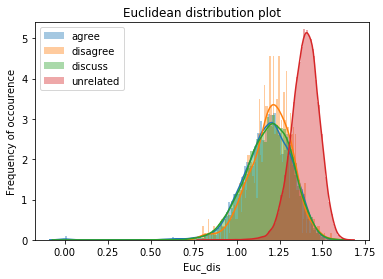

In [51]:
#plot euclidean distribution for 4 stances
euc_agree = new_train[new_train['Stance'] == 'agree']
euc_disagree = new_train[new_train['Stance'] == 'disagree']
euc_discuss = new_train[new_train['Stance'] == 'discuss']
euc_unrelated = new_train[new_train['Stance'] == 'unrelated']

sns.distplot(euc_agree['Euc_dis'], bins = 100, label='agree')
sns.distplot(euc_disagree['Euc_dis'], bins = 100, label='disagree')
sns.distplot(euc_discuss['Euc_dis'], bins = 100, label='discuss')
sns.distplot(euc_unrelated['Euc_dis'], bins = 100, label='unrelated')
plt.title("Euclidean distribution plot")
plt.xlabel("Euc_dis")
plt.ylabel("Frequency of occourence")
plt.legend()
plt.show()

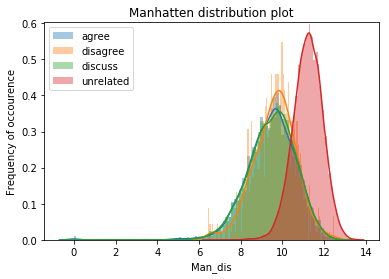

In [59]:
#plot manhattan distribution for 4 stances
man_agree = new_train[new_train['Stance'] == 'agree']
man_disagree = new_train[new_train['Stance'] == 'disagree']
man_discuss = new_train[new_train['Stance'] == 'discuss']
man_unrelated = new_train[new_train['Stance'] == 'unrelated']

sns.distplot(man_agree['Man_dis'], bins = 100, label='agree')
sns.distplot(man_disagree['Man_dis'], bins = 100, label='disagree')
sns.distplot(man_discuss['Man_dis'], bins = 100, label='discuss')
sns.distplot(man_unrelated['Man_dis'], bins = 100, label='unrelated')

#sns.distplot(new_train['Man_dis'], bins = 100)
plt.title("Manhatten distribution plot")
plt.xlabel("Man_dis")
plt.ylabel("Frequency of occourence")
plt.legend()
plt.show()

In [56]:
#plot cosine similarities distribution for 4 stances
cos_agree = new_train[new_train['Stance'] == 'agree']
cos_disagree = new_train[new_train['Stance'] == 'disagree']
cos_discuss = new_train[new_train['Stance'] == 'discuss']
cos_unrelated = new_train[new_train['Stance'] == 'unrelated']

x = cos_agree['cos'].astype(float)
y = cos_disagree['cos'].astype(float)
z = cos_discuss['cos'].astype(float)
w = cos_unrelated['cos'].astype(float)


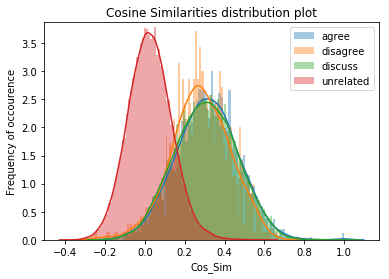

In [60]:
sns.distplot(x, bins = 100, label='agree')
sns.distplot(y, bins = 100,label='disagree')
sns.distplot(z, bins = 100,label='discuss')
sns.distplot(w, bins = 100,label='unrelated')
plt.title("Cosine Similarities distribution plot")
plt.xlabel("Cos_Sim")
plt.ylabel("Frequency of occourence")
plt.legend()
plt.show()

In [100]:
train_stance_1234 = pd.read_csv('train_stances_1234.csv')
val_stance_1234 = pd.read_csv('val_stances_1234.csv')

In [101]:
stance = train_stance_1234.groupby(['Stance']).mean().reset_index()
stance.drop(['Unnamed: 0','Body ID'],axis =1, inplace = True)
stance.reset_index()
stance

,Stance,S
0,agree,1.0
1,disagree,2.0
2,discuss,3.0
3,unrelated,4.0


In [35]:
train_all=new_train.reset_index()
val_all=new_val.reset_index()

In [41]:
# convert 4 classes in to numbers
train_LR = pd.merge(train_all,stance,left_on='Stance', right_on='Stance', how='left')
train_LR

,index,Headline,Body ID,Stance,articleBody,Clean_headline,Clean_body,cos,Body_Vec,Head_Vec,Euc_dis,Man_dis,S
0,35860,What was fake on the Internet this week: Obama...,550,agree,"For exactly seven more hours, retailers will b...","[wa, fake, internet, thi, week, , obama, , p...","[exactli, seven, hour, , retail, stock, back ...",[[0.133626998707]],"[[-0.0102357328914, 0.146213103006, -0.0733135...","[[-0.0592382404465, 0.0966672524653, -0.051462...",1.369244,11.380623,1.0
1,48092,Banksy 'Arrested & Real Identity Revealed' Is ...,2362,agree,Banksy has not been arrested. Let's not bury t...,"[banksi, arrest, , real, ident, reveal, , h...","[banksi, ha, arrest, , let, s, buri, lede, ...",[[0.182882722381]],"[[0.0805932704728, 0.0195603267399, -0.1165669...","[[-0.0215952147484, -0.076010826141, -0.060763...",1.304833,10.499774,1.0
2,23596,Dog abandoned at railway station with suitcase...,2523,agree,THE hunt is on to find the owner of a dog who ...,"[dog, abandon, railway, station, suitcas, set,...","[hunt, find, owner, dog, wa, abandon, railway,...",[[0.236399668271]],"[[-0.144399530831, 0.0293725323039, -0.0150591...","[[0.0269612923095, -0.0722363314434, 0.0642616...",1.491089,11.609034,1.0
3,11507,Pictured: Libyan Islamist rebels pose with pla...,2208,agree,Islamist militias in Libya took control of nea...,"[pictur, , libyan, islamist, rebel, pose, pla...","[islamist, militia, libya, took, control, near...",[[0.329218841589]],"[[-0.0608516042724, -0.133093735441, -0.106915...","[[0.106696717146, -0.0584939856887, -0.0793102...",0.992613,8.067252,1.0
4,26353,Michelle Obama Not Blurred Out on Saudi TV,1975,agree,Video clips circulated online Tuesday that pur...,"[michel, obama, blur, saudi, tv]","[video, clip, circul, onlin, tuesday, purport,...",[[0.52332772718]],"[[-0.131639097294, 0.089476970824, 0.025546948...","[[-0.0597367451458, 0.137562188688, 0.28649998...",1.065571,8.712716,1.0
5,25920,Dog found abandoned outside railway station wi...,626,agree,The suitcase held a number of the dog's belong...,"[dog, found, abandon, outsid, railway, station...","[suitcas, held, number, dog, s, belong, , in...",[[0.462116894788]],"[[-0.181085297593, -0.0909841214676, -0.154606...","[[0.0847898619774, -0.161907998247, 0.08389410...",1.178918,9.459025,1.0
6,14907,MCDONALD’S WILL STOP SERVING OVERWEIGHT CUSTOM...,2184,agree,Obesity rates in America have more than double...,"[mcdonald, , stop, serv, overweight, custom, ...","[obes, rate, america, doubl, last, , decad, h...",[[0.337802383834]],"[[-0.0801768359385, -0.0741422772241, -0.19048...","[[0.0768205648166, 0.0323333350296, -0.0979425...",1.073421,8.607643,1.0
7,25411,Sugarhill Gang's Big Bank Hank Dead At 57,993,agree,Sugarhill Gang founder Henry 'Big Bank Hank' J...,"[sugarhil, gang, s, big, bank, hank, dead, ]","[sugarhil, gang, founder, henri, big, bank, h...",[[0.563423060582]],"[[-0.0251944788802, 0.0174821226859, -0.077872...","[[0.0271569507349, 0.0145293250901, 0.01421006...",1.026446,8.412511,1.0
8,39013,"McDonald’s Removing Big Mac? Nope, ‘Apple Pies...",1777,agree,An article saying McDonald’s is removing the B...,"[mcdonald, , remov, big, mac, , nope, , , ...","[articl, say, mcdonald, , remov, big, mac, ,...",[[0.571716739233]],"[[0.0277664424907, -0.0192776952555, 0.1229016...","[[0.045321544185, 0.100702119668, 0.0442066368...",0.963304,7.491118,1.0
9,24999,Does ISIS Have Ebola? Probably Not! Media Repo...,2138,agree,The Islamic State (Isis) operating in Iraq doe...,"[doe, isi, ebola, , probabl, , media, report...","[islam, state, , isi, , oper, iraq, doe, ebo...",[[0.342722895757]],"[[-0.0486182365252, 0.136353586776, -0.0488324...","[[0.0802994105119, 0.094890329033, 0.003323809...",1.251819,10.017994,1.0


In [42]:
val_LR = pd.merge(val_all,stance,left_on='Stance', right_on='Stance', how='left')
val_LR

,index,Headline,Body ID,Stance,articleBody,Clean_headline,Clean_body,cos,Head_Vec,Body_Vec,Euc_dis,Man_dis,S
0,24340,Zack Snyder Responds to Fake Stolen Batmobile ...,2519,agree,"On Friday, a rumor cropped up that one of the ...","[zack, snyder, respond, fake, stolen, batmobil...","[friday, , rumor, crop, one, new, batmobil, v...",[[0.311916101275]],"[[-0.0426800629745, 0.13821860246, 0.062623272...","[[0.0628539507646, -0.105021358449, 0.04669144...",1.173102,9.235498,1.0
1,1065,"Dead for 48 minutes, this Catholic Priest clai...",1849,agree,After being officially dead for 48 minutes and...,"[dead, , minut, , thi, cathol, priest, clai...","[offici, dead, , minut, hi, heart, restart, ...",[[0.354202098885]],"[[-0.148028603081, -0.0988967406852, 0.1073416...","[[-0.100024468347, 0.00215287847313, 0.0213777...",1.136484,8.974802,1.0
2,44460,Macaulay Culkin Hasn’t Died Despite What Every...,1555,agree,"Once again, rumors that Macaulay Culkin died h...","[macaulay, culkin, , die, despit, everyon, sa...","[onc, , rumor, macaulay, culkin, die, flouris...",[[0.137419287886]],"[[-0.0544743115629, 0.173433861485, -0.0316909...","[[0.0763711424669, 0.0500833356132, 0.02544938...",1.313454,10.467725,1.0
3,41583,Homeless man receives $100... then shocks ever...,1245,agree,YouTuber Josh Paler Lin is normally a prankste...,"[homeless, man, receiv, , , , shock, ev...","[youtub, josh, paler, lin, normal, prankster, ...",[[0.275334647722]],"[[0.122741256111, 0.134034709692, 0.2737713579...","[[0.00654751500301, 0.180203385513, -0.0435347...",1.203882,9.882858,1.0
4,34469,Bosnia: Seven underage girls return from five ...,1804,agree,"Seven girls from a Bosnian school, all aged be...","[bosnia, , seven, underag, girl, return, five...","[seven, girl, bosnian, school, , age, , ,...",[[0.347841380324]],"[[-0.109808052625, -0.0288419339159, 0.0112831...","[[0.0350508883121, 0.00288236973757, -0.103789...",1.142067,9.251774,1.0
5,24464,Bugatti Veyron Vandalized With Penis Graffiti?...,1453,agree,This picture of a penis spraypainted on a £1.5...,"[bugatti, veyron, vandal, peni, graffiti, , v...","[thi, pictur, peni, spraypaint, , million,...",[[0.266687713759]],"[[0.100718239984, 0.24203148541, -0.2054246105...","[[-0.0225131240661, 0.112592065568, 0.05965676...",1.211043,9.415840,1.0
6,24294,'Jihadi John': Isis fighter named as Mohammed ...,2165,agree,"The masked Islamic State militant known as ""Ji...","[ jihadi, john, , , isi, fighter, name, moha...","[mask, islam, state, milit, known, , jihadi,...",[[0.0255147889446]],"[[-0.0971890822946, -0.0831534782151, -0.12816...","[[0.0321794674882, -0.0140313759303, -0.182935...",1.396055,11.728148,1.0
7,49499,Tropical spider burrowed under man's skin thro...,1104,agree,Spotting a spider on the floor may give you a ...,"[tropic, spider, burrow, man, s, skin, append...","[spot, spider, floor, may, give, fright, , im...",[[0.447140009927]],"[[-0.1594918077, -0.0157805322486, -0.00913722...","[[-0.0845206447924, 0.092753815556, 0.11650900...",1.051532,8.225801,1.0
8,2922,Turkish Leader Says U.S. Airdrop Aided ISIS Mi...,1363,agree,Erdogan argued that the Turkish weapons drop h...,"[turkish, leader, say, u s , airdrop, aid, isi...","[erdogan, argu, turkish, weapon, drop, ha, har...",[[0.32288566637]],"[[0.00273160615349, 0.0420272479229, -0.032274...","[[0.11689128478, -0.216189898199, -0.024337793...",1.163713,9.382765,1.0
9,45985,"Man cuts off manhood, throws it in the bin, af...",1799,agree,Oliver Ilic mutilated himself after his girlfr...,"[man, cut, manhood, , throw, bin, , girlfrie...","[oliv, ilic, mutil, hi, girlfriend, threw, bec...",[[0.0166797527008]],"[[0.179436613665, 0.175859664522, -0.053941024...","[[0.111333049074, 0.0861140942124, 0.071754917...",1.402370,10.826532,1.0


In [50]:
train_LR.cos = train_LR.cos.astype(float)
val_LR.cos = val_LR.cos.astype(float)

In [129]:
test_LR = test_all[test_all['cos']!=0]
test_LR.shape

(25370, 12)

In [130]:
z = test_all[test_all['cos']==0]
z.shape

(43, 12)

In [131]:
test_LR.cos = test_all.cos.astype(float)

/Users/jennyyang/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [133]:
train_LR=pd.read_pickle('train_LR.csv')
val_LR=pd.read_pickle('val_LR.csv')

# Regressions

In [134]:
val_features = val_LR[['cos','Man_dis','Euc_dis']]
val_x1 = val_LR['cos']
val_x2 = val_LR['Man_dis']
val_x3 = val_LR['Euc_dis']
val_y = val_LR['S']

train_features = train_LR[['cos','Man_dis','Euc_dis']]
train_x1 = train_LR['cos']
train_x2 = train_LR['Man_dis']
train_x3 = train_LR['Euc_dis']
train_y = train_LR['S']

test_features = test_LR[['cos','Man_dis','Euc_dis']]
test_x1 = test_LR['cos']
test_x2 = test_LR['Man_dis']
test_x3 = test_LR['Euc_dis']
test_y = test_LR['S']

In [471]:
print('Training set - Real Stance count')
train_s = train_LR.groupby(['S']).count().reset_index()
train_s['Percent%'] = train_s['Stance']/train_s['Stance'].sum()*100
train_s = train_s[['S', 'Stance','Percent%']]
print(train_s)

print('Validation set - Real Stance count')
val_s = val_LR.groupby(['S']).count().reset_index()
val_s['Percent%'] = val_s['Stance']/val_s['Stance'].sum()*100
val_s = val_s[['S', 'Stance', 'Percent%']]
print(val_s)

print('Test set - Real Stance count')
test_s = test_LR.groupby(['S']).count().reset_index()
test_s['Percent%'] = test_s['Stance']/test_s['Stance'].sum()*100
test_s = test_s[['S', 'Stance', 'Percent%']]
print(test_s)

Training set - Real Stance count
     S  Stance   Percent%
0  1.0    3310   7.359808
1  2.0     756   1.680971
2  3.0    8018  17.828078
3  4.0   32890  73.131142
Validation set - Real Stance count
     S  Stance   Percent%
0  1.0     368   7.362945
1  2.0      84   1.680672
2  3.0     891  17.827131
3  4.0    3655  73.129252
Test set - Real Stance count
     S  Stance   Percent%
0  1.0    1903   7.500985
1  2.0     697   2.747339
2  3.0    4448  17.532519
3  4.0   18322  72.219156


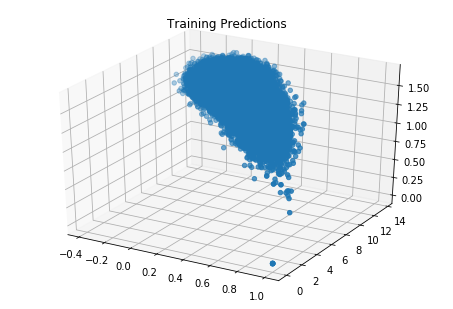

In [455]:
# Ploting the scores as scatter plot
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(train_x1, train_x2, train_x3)
plt.title("Training Predictions")
plt.show()

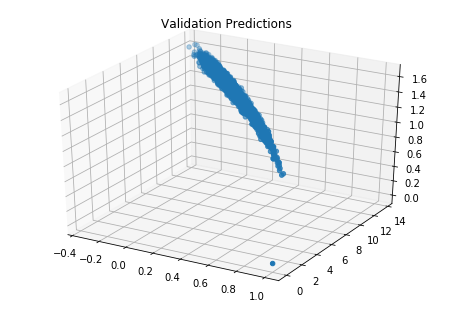

In [454]:
# Ploting the scores as scatter plot
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(val_x1, val_x2, val_x3)
plt.title("Validation Predictions")
plt.show()

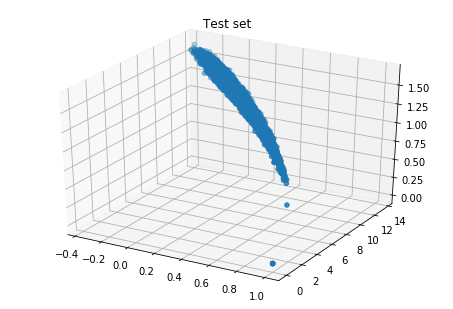

In [453]:
# Ploting the scores as scatter plot
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(test_x1, test_x2, test_x3)
plt.title("Test set")
plt.show()

In [57]:
# Metric1 - RMSE (root mean square)
def rmse(Y, Y_pred):
    rmse = np.sqrt(sum((Y - Y_pred) ** 2) / len(Y))
    return rmse

In [58]:
# Metric2 - R2 Score
def r2_score(Y, Y_pred):
    mean_y = np.mean(Y)
    ss_tot = sum((Y - mean_y) ** 2)
    ss_res = sum((Y - Y_pred) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    return r2

In [235]:
train_y_mean = train_LR['S'].mean()
val_y_mean val_LR['S'].mean()
test_y_mean test_LR['S'].mean()

3.567305554320274
3.5672268907563027
3.544698462751281


## Linear

In [138]:
# Initialize variables
m = len(train_x1)
x0 = np.ones(m)
n = len(val_x1)
x0_v = np.ones(n)
p = len(test_x1)
x0_t = np.ones(p)

# Additional x0 for the intercept term
X = np.array([x0, train_x1, train_x2, train_x3]).T
X_v = np.array([x0_v, val_x1, val_x2, val_x3]).T
X_t = np.array([x0_t, test_x1, test_x2, test_x3]).T

Y = np.array(train_y)
Y_v = np.array(val_y)
Y_t = np.array(test_y)

# Initial Coefficients
theta = np.array([0, 0, 0, 0])

# Initial Learning Rate
alpha = 0.0001

In [139]:
def linear_cost_func(X, Y, theta):
    m = len(Y)
    c = np.sum((X.dot(theta) - Y) ** 2)/(2 * m)
    return c

In [140]:
inital_cost = linear_cost_func(X, Y, theta)
print("Training: Initial Cost")
print(inital_cost)

Training: Initial Cost
6.72317338907


In [141]:
inital_cost = linear_cost_func(X_v, Y_v, theta)
print("Validation: Initial Cost")
print(inital_cost)

Validation: Initial Cost
6.72298919568


In [142]:
inital_cost = linear_cost_func(X_t, Y_t, theta)
print("Test: Initial Cost")
print(inital_cost)

Test: Initial Cost
6.65894757588


In [143]:
def gradient_descent(X, Y, theta, alpha, iterations):
    cost_history = [0] * iterations
    m = len(Y)
    for iteration in range(iterations):
        #Hypothesis 
        H = X.dot(theta)
        #Lost function
        loss = H - Y
        #Gradient Calculation
        gradient = X.T.dot(loss) / m
        #Update theta using Gradient
        theta = theta - alpha * gradient
        #New Cost Value
        cost = linear_cost_func(X, Y, theta)
        cost_history[iteration] = cost  
    return theta, cost_history

In [239]:
# 10000 Iterations to find the best learning rate and min cost 
least_cost =[] 
for i in (0.15,0.01,0.009, 0.008, 0.007):
    new_theta, cost_history = gradient_descent(X, Y, theta, i, 10000)
    least_cost.append(cost_history[-1])
    print('Learning rate: ', i)
    print("Cost coefficients: ", new_theta)
    print("Least_cost: ",least_cost)

/Users/jennyyang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in square
  This is separate from the ipykernel package so we can avoid doing imports until


Learning rate:  0.15
Cost coefficients:  [ nan  nan  nan  nan]
Least_cost:  [nan]
Learning rate:  0.01
Cost coefficients:  [ 0.19428366 -1.3716389   0.27910412  0.37677942]
Least_cost:  [nan, 0.21561185295383672]
Learning rate:  0.009
Cost coefficients:  [ 0.14706125 -1.33644859  0.2869528   0.34633498]
Least_cost:  [nan, 0.21561185295383672, 0.21605774833333866]
Learning rate:  0.008
Cost coefficients:  [ 0.09946028 -1.29504938  0.29487928  0.31513722]
Least_cost:  [nan, 0.21561185295383672, 0.21605774833333866, 0.21655975302156849]
Learning rate:  0.007
Cost coefficients:  [ 0.05245286 -1.24500712  0.30277568  0.28317443]
Least_cost:  [nan, 0.21561185295383672, 0.21605774833333866, 0.21655975302156849, 0.21714039007497321]


In [240]:
# 10000 Iterations to find the best learning rate and min cost 
least_cost =[] 

new_theta, cost_history = gradient_descent(X, Y, theta, 0.01, 10000)
least_cost.append(cost_history[-1])

print("Cost coefficients: ", new_theta)
print("Least_cost: ",least_cost)

Cost coefficients:  [ 0.19428366 -1.3716389   0.27910412  0.37677942]
Least_cost:  [0.21561185295383672]


In [243]:
Y_pred = X.dot(new_theta)
Y_pred = [round(y) for y in Y_pred]

print('Training - Stance count')
print('Agree:', Y_pred.count(1),(Y_pred.count(1)/len(Y_pred))*100, '%')
print('Disgree:', Y_pred.count(2),(Y_pred.count(2)/len(Y_pred))*100, '%')
print('Discuss:', Y_pred.count(3),(Y_pred.count(3)/len(Y_pred))*100, '%')
print('Unrelated:', Y_pred.count(4),(Y_pred.count(4)/len(Y_pred))*100, '%')

Training - Stance count
Agree: 89 0.19789211544447904 %
Disgree: 2729 6.067950371325654 %
Discuss: 12065 26.82661093075999 %
Unrelated: 29939 66.56957353137368 %


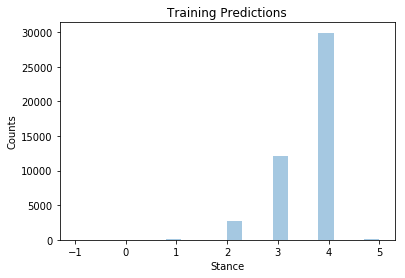

In [242]:
sns.distplot(Y_pred,bins = 20,kde = False)
plt.title("Training Predictions")
plt.xlabel("Stance")
plt.ylabel("Counts")
#plt.legend()
plt.show()

In [245]:
Yv_pred = X_v.dot(new_theta)
Yv_pred = [round(y) for y in Yv_pred]
print('Validation - Stance count')
print('Agree:', Yv_pred.count(1),(Yv_pred.count(1)/len(Yv_pred))*100, '%')
print('Disgree:', Yv_pred.count(2),(Yv_pred.count(2)/len(Yv_pred))*100, '%')
print('Discuss:', Yv_pred.count(3),(Yv_pred.count(3)/len(Yv_pred))*100, '%')
print('Unrelated:', Yv_pred.count(4),(Yv_pred.count(4)/len(Yv_pred))*100, '%')

Validation - Stance count
Agree: 14 0.2801120448179272 %
Disgree: 304 6.082432973189276 %
Discuss: 1497 29.951980792316927 %
Unrelated: 3085 61.724689875950375 %


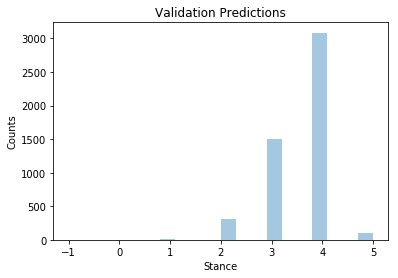

In [246]:
sns.distplot(Yv_pred,bins = 20,kde = False)
plt.title("Validation Predictions")
plt.xlabel("Stance")
plt.ylabel("Counts")
plt.show()

In [247]:
Yt_pred = X_t.dot(new_theta)
Yt_pred = [round(y) for y in Yt_pred]
print('Testing - Stance count')
print('Agree:', Yt_pred.count(1), (Yt_pred.count(1)/len(Yt_pred))*100, '%')
print('Disgree:', Yt_pred.count(2),(Yt_pred.count(2)/len(Yt_pred))*100, '%')
print('Discuss:', Yt_pred.count(3),(Yt_pred.count(3)/len(Yt_pred))*100, '%')
print('Unrelated:', Yt_pred.count(4),(Yt_pred.count(4)/len(Yt_pred))*100, '%')

Testing - Stance count
Agree: 93 0.3665746945210879 %
Disgree: 1698 6.692944422546314 %
Discuss: 6853 27.012219156484036 %
Unrelated: 16138 63.610563657863615 %


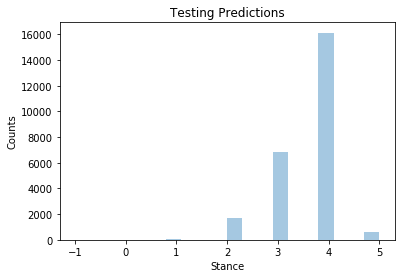

In [248]:
sns.distplot(Yt_pred,bins = 20,kde = False)
plt.title("Testing Predictions")
plt.xlabel("Stance")
plt.ylabel("Counts")
plt.show()

In [250]:
train_y_mean = train_LR['S'].mean()
val_y_mean  = val_LR['S'].mean()
test_y_mean = test_LR['S'].mean()

In [254]:
# Trainning set predictions evaluation
print('Training Evaluation')
print("RMSE: ", rmse(Y, Y_pred))
print("NRMSE: ",rmse(Y, Y_pred)/train_y_mean)
print("R2 Score: ", r2_score(Y, Y_pred))


Training Evaluation
RMSE:  0.682692672053
NRMSE:  0.191374879908
R2 Score:  0.353290408684


In [262]:
# Validation set predictions evaluation
print('Validation Evaluation')
print("RMSE: ",rmse(Y_v, Yv_pred))
print("NRMSE: ", rmse(Y_v, Yv_pred)/val_y_mean)
print("R2 Score: ", r2_score(Y_v, Yv_pred))


Validation Evaluation
RMSE:  0.744191862769
NRMSE:  0.208619155876
R2 Score:  0.231732503939


In [260]:
# Validation set predictions evaluation
print('Testing Evaluation')
print("RMSE: ", rmse(Y_t, Yt_pred))
print("NRMSE: ", rmse(Y_t, Yt_pred)/test_y_mean)
print("R2 Score: ", r2_score(Y_t, Yt_pred))


Testing Evaluation
RMSE:  0.751191406873
NRMSE:  0.211919692117
R2 Score:  0.250620763933


## Logistic 
Lost Function: \begin{eqnarray}
L(\mathbf{w}) = -\sum_{i=1}^{N}\left[ y^i \log\left(g\left(\left<\mathbf{x}^i,\mathbf{w}\right>\right)\right)  + (1-y^i) \log\left(1-g\left(\left<\mathbf{x}^i,\mathbf{w}\right>\right)\right)\right].
\end{eqnarray}

In [145]:
# Initialize variables
X = np.array([train_x1, train_x2, train_x3]).T
X_t = np.array([test_x1, test_x2, test_x3]).T
X_v = np.array([val_x1, val_x2, val_x3]).T
# Initial Coefficients
theta = np.array([0, 0, 0, 0])
Y = np.array(train_y)
Y_v = np.array(val_y)
Y_t = np.array(test_y)

# Learning Rate
alpha = 0.00001

In [146]:
print(X.shape, Y.shape)
print(X_v.shape, Y_v.shape)
print(X_t.shape, Y_t.shape)

(44974, 3) (44974,)
(4998, 3) (4998,)
(25370, 3) (25370,)


In [147]:
# Training params
rows = X.shape[0]  
params = X.shape[1]
all_theta = np.zeros((4, params+1))
X = np.insert(X, 0, values=np.ones(rows), axis=1)
theta = np.zeros(params+1 )

y_0 = np.array([1 if label == 0 else 0 for label in Y])  
y_0 = np.reshape(y_0, (rows, 1))

X.shape, y_0.shape, theta.shape, all_theta.shape

((44974, 4), (44974, 1), (4,), (4, 4))

In [148]:
# Validation params
rows = X_v.shape[0]  
params = X_v.shape[1]
all_theta = np.zeros((4, params+1))
X_v = np.insert(X_v, 0, values=np.ones(rows), axis=1)
theta = np.zeros(params+1 )

yv_0 = np.array([1 if label == 0 else 0 for label in Y_v])  
yv_0 = np.reshape(yv_0, (rows, 1))

X_v.shape, yv_0.shape, theta.shape, all_theta.shape

((4998, 4), (4998, 1), (4,), (4, 4))

In [149]:
# Testing params
rows = X_t.shape[0]  
params = X_t.shape[1]
all_theta = np.zeros((4, params+1))
X_t = np.insert(X_t, 0, values=np.ones(rows), axis=1)
theta = np.zeros(params+1 )

yt_0 = np.array([1 if label == 0 else 0 for label in Y_t])  
yt_0 = np.reshape(yt_0, (rows, 1))

X_t.shape, yt_0.shape, theta.shape, all_theta.shape

((25370, 4), (25370, 1), (4,), (4, 4))

In [150]:
def sigmoid(z):  
    s = 1 / (1 + np.exp(-z))
    return s

In [151]:
def cost(theta, X, y, alpha):  
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    a = np.multiply(-y, np.log(sigmoid(X * theta.T)))
    b = np.multiply((1 - y), np.log(1 - sigmoid(X * theta.T)))
    reg = (alpha / 2 * len(X)) * np.sum(np.power(theta[:,1:theta.shape[1]], 2))
    c = np.sum(a - b) / (len(X)) + reg
    return c

In [152]:
def log_gradient(theta, X, y, alpha):  
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)

    parameters = int(theta.ravel().shape[1])
    grad = np.zeros(parameters)
    error = sigmoid(X * theta.T) - y

    for i in range(parameters):
        term = np.multiply(error, X[:,i])
        if (i == 0):
            grad[i] = np.sum(term) / len(X)
        else:
            grad[i] = (np.sum(term) / len(X)) + ((alpha / len(X)) * theta[:,i])
    return grad

In [157]:
from scipy.optimize import minimize

def one_vs_all(X, y, num_labels, learning_rate):  
    rows = X.shape[0]
    params = X.shape[1]
    # k*(n+1) array for the parameters for each k classifiers
    all_theta = np.zeros((num_labels, params+1))
    # additional column for the intercept term
    X = np.insert(X, 0, values=np.ones(rows), axis=1)
    for i in range(1, num_labels ):
        theta = np.zeros(params+1)
        y_i = np.array([1 if label == i else 0 for label in y])
        y_i = np.reshape(y_i, (rows, 1))
        # minimize the cost function witih gradient and truncated Newton (TNC) algorithm
        Min = minimize(fun=cost, x0=theta, args=(X, y_i, learning_rate), method='TNC', jac=log_gradient)
        all_theta[i-1,:] = Min.x
    return all_theta, Min

In [154]:
def predict_all(X, all_theta):  
    rows = X.shape[0]
    params = X.shape[1]
    num_labels = all_theta.shape[0]
    # add ones for matching shape
    X = np.insert(X, 0, values=np.ones(rows), axis=1)
    # convert to matrices
    X = np.matrix(X)
    all_theta = np.matrix(all_theta)
    # compute the class probability 
    H = sigmoid(X * all_theta.T)
    # create array of the index with the maximum probability
    h_argmax = np.argmax(H, axis=1)
    # labels are 1-4 while prediction are 0-3
    h_argmax = h_argmax + 1
    return h_argmax

In [188]:
# Training Theta
all_theta , Min = one_vs_all(X, Y, 4, 0.000001)  
all_theta.shape

(4, 5)

In [189]:
Min

     fun: 0.30917465980799069
     jac: array([ -7.65560599e-06,  -7.65560599e-06,  -6.16319242e-06,
         1.30341995e-07,   1.37734881e-05])
 message: 'Max. number of function evaluations reached'
    nfev: 100
     nit: 15
  status: 3
 success: False
       x: array([ 2.20438127,  2.20438127,  5.81908912,  0.04276175, -5.66252598])

In [190]:
y_pred = predict_all(X, all_theta)  
y_pred = np.array(y_pred).flatten()
y_pred = y_pred.tolist()
print('Training (logistic) - Stance count')
print('Agree:', y_pred.count(1), (y_pred.count(1)/len(y_pred))*100, '%')
print('Disgree:', y_pred.count(2),(y_pred.count(2)/len(y_pred))*100, '%')
print('Discuss:', y_pred.count(3),(y_pred.count(3)/len(y_pred))*100, '%')
print('Unrelated:', y_pred.count(4),(y_pred.count(4)/len(y_pred))*100, '%')

Training (logistic) - Stance count
Agree: 0 0.0 %
Disgree: 0 0.0 %
Discuss: 5591 12.431627162360474 %
Unrelated: 39383 87.56837283763953 %


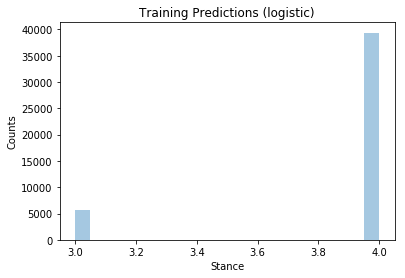

In [191]:
sns.distplot(y_pred,bins = 20,kde = False)
plt.title("Training Predictions (logistic)")
plt.xlabel("Stance")
plt.ylabel("Counts")
plt.show()

In [264]:
# Trainning set predictions evaluation
print('Training results evaluation - logistic')
print("RMSE: ", rmse(Y, y_pred))
print("NRMSE: ", rmse(Y, y_pred)/train_y_mean)
print("R2 Score: ", r2_score(Y, y_pred))


Training results evaluation - logistic
RMSE:  0.799994997094
NRMSE:  0.22425749208
R2 Score:  0.111958295556


In [193]:
# Validataion theta
alpha = 0.000001
all_theta, Min = one_vs_all(X_v, Y_v, 4,alpha)  
all_theta

array([[ -9.50842917e+00,  -9.50842916e+00,   1.53803276e+01,
          3.34480020e-01,   8.11460263e+00],
       [ -1.17163090e+01,  -1.17163090e+01,   1.57830773e+01,
         -1.28597554e-02,   1.31274017e+01],
       [ -2.89694868e+01,  -2.89694868e+01,   4.07715150e+01,
          3.93497014e-01,   3.54758881e+01],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00]])

In [194]:
# Validation Prediction Reults
yv_pred = predict_all(X_v, all_theta)  
yv_pred = np.array(yv_pred).flatten()
yv_pred = yv_pred.tolist()
print('Validation (logistic) - Stance count')
print('Agree:', yv_pred.count(1), (yv_pred.count(1)/len(yv_pred))*100, '%')
print('Disgree:', yv_pred.count(2),(yv_pred.count(2)/len(yv_pred))*100, '%')
print('Discuss:', yv_pred.count(3),(yv_pred.count(3)/len(yv_pred))*100, '%')
print('Unrelated:', yv_pred.count(4),(yv_pred.count(4)/len(yv_pred))*100, '%')

Validation (logistic) - Stance count
Agree: 2 0.040016006402561026 %
Disgree: 0 0.0 %
Discuss: 658 13.165266106442578 %
Unrelated: 4338 86.79471788715486 %


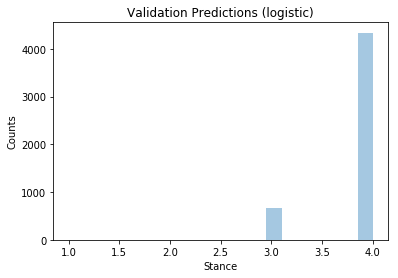

In [195]:
sns.distplot(yv_pred,bins = 20,kde = False)
plt.title("Validation Predictions (logistic)")
plt.xlabel("Stance")
plt.ylabel("Counts")
plt.show()

In [265]:
# Validation set predictions evaluation
print('Validation results evaluation - logistic')
print("RMSE: ",rmse(Y_v, yv_pred))
print("NRMSE: ",rmse(Y_v, yv_pred)/val_y_mean)
print("R2 Score: ",r2_score(Y_v, yv_pred))


Validation results evaluation - logistic
RMSE:  0.793253868998
NRMSE:  0.222372698259
R2 Score:  0.127094915061


In [197]:
# Testing theta
all_theta, Min = one_vs_all(X_t, Y_t, 4, alpha)  
all_theta.shape

(4, 5)

In [198]:
Min

     fun: 0.32069340916393524
     jac: array([ -5.19831792e-04,  -5.19831792e-04,  -1.01620504e-03,
         6.32934674e-04,  -3.01959900e-05])
 message: 'Max. number of function evaluations reached'
    nfev: 100
     nit: 23
  status: 3
 success: False
       x: array([-16.01359548, -16.01359548,  25.04101036,   0.25293402,  18.52586996])

In [199]:
# Testing Prediction Reults
yt_pred = predict_all(X_t, all_theta)  
yt_pred = np.array(yt_pred).flatten()
yt_pred = yt_pred.tolist()
print('Testing (logistic) - Stance count')
print('Agree:', yt_pred.count(1), (yt_pred.count(1)/len(yt_pred))*100, '%')
print('Disgree:', yt_pred.count(2),(yt_pred.count(2)/len(yt_pred))*100, '%')
print('Discuss:', yt_pred.count(3),(yt_pred.count(3)/len(yt_pred))*100, '%')
print('Unrelated:', yt_pred.count(4),(yt_pred.count(4)/len(yt_pred))*100, '%')

Testing (logistic) - Stance count
Agree: 0 0.0 %
Disgree: 0 0.0 %
Discuss: 2973 11.718565234528972 %
Unrelated: 22397 88.28143476547103 %


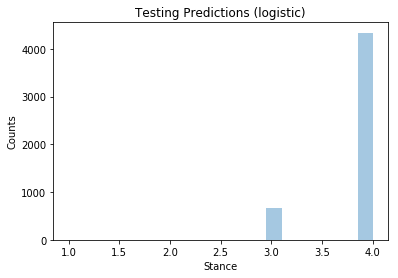

In [200]:
sns.distplot(yv_pred,bins = 20,kde = False)
plt.title("Testing Predictions (logistic)")
plt.xlabel("Stance")
plt.ylabel("Counts")
plt.show()

In [266]:
# Testing set predictions evaluation
print('Testing results evaluation - logistic')
print("RMSE: ", rmse(Y_t, yt_pred))
print("NRMSE: ",rmse(Y_t, yt_pred)/test_y_mean)
print("R2 Score: ", r2_score(Y_t, yt_pred))

Testing results evaluation - logistic
RMSE:  0.837342870263
NRMSE:  0.236224005811
R2 Score:  0.068876931324


## KL Divergence

In [ ]:
## First calculate all vector probability distribution, smoothing with laplace method, language model based representation

In [282]:
# Calculated probabilities distribution for headlines in training set with laplace smoothing
new_train['Head_Vec_Prob'] = (new_train['Head_Vec']+1)/(sum(new_train['Head_Vec'])+len(new_train['Head_Vec']))
new_train['Head_Vec_Prob']

35860    [[2.0498770133e-05, 2.37522622848e-05, 2.15156...
48092    [[2.13189945129e-05, 2.00122992243e-05, 2.1304...
23596    [[2.23770186796e-05, 2.00940494433e-05, 2.4140...
11507    [[2.41144172596e-05, 2.03916892242e-05, 2.0883...
26353    [[2.04879079427e-05, 2.46379887886e-05, 2.9181...
25920    [[2.36370768661e-05, 1.81518879129e-05, 2.4585...
14907    [[2.34634295118e-05, 2.23588805847e-05, 2.0461...
25411    [[2.23812819875e-05, 2.19732708996e-05, 2.3005...
39013    [[2.27770802031e-05, 2.38396518042e-05, 2.3685...
24999    [[2.35392319745e-05, 2.37137766354e-05, 2.2758...
300      [[2.17283726149e-05, 2.34808396958e-05, 2.0518...
18089    [[2.55276305809e-05, 2.65426526789e-05, 2.3978...
20518    [[2.33134824422e-05, 2.47797734285e-05, 2.0140...
9146     [[2.42373423032e-05, 2.11309304161e-05, 2.2014...
9977     [[2.03738658138e-05, 2.00456847115e-05, 2.2305...
44069    [[2.09387987506e-05, 2.09094774151e-05, 1.9953...
13817    [[1.68820397872e-05, 2.12769063369e-05, 2.3275.

In [283]:
# Calculated probabilities distribution for bodies in training set with laplace smoothing
new_train['Body_Vec_Prob'] = (new_train['Body_Vec']+1)/(sum(new_train['Body_Vec'])+len(new_train['Body_Vec']))
new_train['Body_Vec_Prob'] 

35860    [[2.28962130921e-05, 2.44594597522e-05, 2.1152...
48092    [[2.49973600874e-05, 2.17567699334e-05, 2.0165...
23596    [[1.97926024557e-05, 2.19661561693e-05, 2.2482...
11507    [[2.17253163286e-05, 1.84992291846e-05, 2.0385...
26353    [[2.0087789517e-05, 2.32487467199e-05, 2.34088...
25920    [[1.89439507503e-05, 1.93978216064e-05, 1.9296...
14907    [[2.12782658167e-05, 1.97572158677e-05, 1.8477...
25411    [[2.2550172477e-05, 2.17124223786e-05, 2.10482...
39013    [[2.37753172732e-05, 2.09279912069e-05, 2.5631...
24999    [[2.20083107789e-05, 2.42490639368e-05, 2.1711...
300      [[1.95546756141e-05, 2.08184850402e-05, 2.3138...
18089    [[2.16725044208e-05, 2.2908019438e-05, 2.18416...
20518    [[2.21712635552e-05, 2.11891262193e-05, 2.2209...
9146     [[2.50691194336e-05, 2.12987241483e-05, 2.3686...
9977     [[1.71090480136e-05, 2.02979451198e-05, 2.2628...
44069    [[2.09063200882e-05, 1.78832420161e-05, 2.2478...
13817    [[1.9229308714e-05, 2.34675771213e-05, 1.97267.

In [284]:
# Calculated probabilities distribution for headlines in validation set with laplace smoothing
new_val['Head_Vec_Prob'] = (new_val['Head_Vec']+1)/(sum(new_val['Head_Vec'])+len(new_val['Head_Vec']))
new_val['Head_Vec_Prob'] 

24340    [[0.000187761844681, 0.000221329053202, 0.0002...
1065     [[0.000167099539991, 0.000175221465183, 0.0002...
44460    [[0.000185448605621, 0.000228176735994, 0.0001...
41583    [[0.000220206392026, 0.000220515486262, 0.0002...
34469    [[0.000174595843766, 0.000188843772902, 0.0002...
24464    [[0.000215886956095, 0.000241515691378, 0.0001...
24294    [[0.000177070837815, 0.000178282776401, 0.0001...
49499    [[0.000164851229513, 0.000191383590524, 0.0002...
2922     [[0.000196668562734, 0.000202624437604, 0.0001...
45985    [[0.000231326211542, 0.000228648438608, 0.0001...
45540    [[0.000165385327861, 0.000164006166014, 0.0002...
31213    [[0.00020798171845, 0.00021429410246, 0.000172...
41614    [[0.000210615553157, 0.000168065780956, 0.0002...
37869    [[0.000185124056433, 0.000167463645047, 0.0002...
2980     [[0.000200346559893, 0.000231625509764, 0.0002...
21279    [[0.000187778986836, 0.000154218681286, 0.0001...
18548    [[0.000193327279549, 0.000202122111545, 0.0001.

In [285]:
# Calculated probabilities distribution for bodies in validation set with laplace smoothing
new_val['Body_Vec_Prob'] = (new_val['Body_Vec']+1)/(sum(new_val['Body_Vec'])+len(new_val['Body_Vec']))
new_val['Body_Vec_Prob'] 

24340    [[0.000221514177578, 0.000171832214546, 0.0002...
1065     [[0.00018756795286, 0.000192409226798, 0.00020...
44460    [[0.000224331356364, 0.000201611677239, 0.0002...
41583    [[0.00020977909977, 0.000226594191115, 0.00019...
34469    [[0.000215719616143, 0.000192549286118, 0.0001...
24464    [[0.000203722441131, 0.000213613096042, 0.0002...
24294    [[0.0002151211704, 0.000189301916583, 0.000167...
49499    [[0.000190799174536, 0.000209804233713, 0.0002...
2922     [[0.000232776341673, 0.000150488312595, 0.0002...
45985    [[0.000231617924742, 0.000208529434551, 0.0002...
45540    [[0.000190971087996, 0.000217287122194, 0.0002...
31213    [[0.000206281227507, 0.000220068196812, 0.0001...
41614    [[0.000187240803085, 0.000203066872843, 0.0001...
37869    [[0.000219650465821, 0.000201530596598, 0.0001...
2980     [[0.00020270269355, 0.00021240346548, 0.000189...
21279    [[0.000187012012083, 0.000197266879371, 0.0002...
18548    [[0.000219065690238, 0.000203381731038, 0.0001.

In [517]:
vector_norm =[]
for vector in new_train['Body_Vec_Prob']:
    vecMean = np.mean(np.array(vector[0])) 
    vecStd = np.std(np.array(vector[0]))
    norm = [(v - vecMean)/vecStd for v in vector[0]]
    vector_norm.append(norm)
new_train['Body_Prob_Norm']=vector_norm
new_train['Body_Prob_Norm']

35860    [0.176281512601, 0.862352345746, -0.5890790496...
48092    [1.32069367207, -0.201409447058, -0.9490574465...
23596    [-1.22086630304, -0.170018471528, 0.0793766958...
11507    [-0.0654334491177, -1.67667861319, -0.73469076...
26353    [-0.927223348267, 0.61904747437, 0.69737392950...
25920    [-1.54274122684, -1.33508567306, -1.3813321549...
14907    [-0.377016631358, -1.05452689589, -1.624430776...
25411    [0.104583259293, -0.278067326127, -0.581442642...
39013    [0.661879499733, -0.607281567113, 1.4890537348...
24999    [-0.0434663083749, 1.02405949924, -0.185061420...
300      [-1.3394303971, -0.708996331311, 0.44832309687...
18089    [-0.398607143411, 0.193218953124, -0.317598956...
20518    [0.124069844919, -0.37702089587, 0.14352275591...
9146     [1.32910645445, -0.373520233698, 0.70483768167...
9977     [-2.62821428726, -1.01105118482, 0.17062207288...
44069    [-0.676656847132, -2.00808471998, 0.0157089981...
13817    [-1.47654350625, 0.723894541828, -1.2182925503.

In [518]:
vector_norm =[]
for vector in new_train['Head_Vec_Prob']:
    vecMean = np.mean(np.array(vector[0])) 
    vecStd = np.std(np.array(vector[0]))
    norm = [(v - vecMean)/vecStd for v in vector[0]]
    vector_norm.append(norm)
new_train['Head_Prob_Norm']=vector_norm
new_train['Head_Prob_Norm']

35860    [-0.96038495552, 0.550628454236, -0.4881092339...
48092    [-0.274688096485, -0.864678094717, -0.28115031...
23596    [-0.0379124503015, -1.06389740449, 0.754671553...
11507    [0.947620247434, -0.742588812675, -0.519068943...
26353    [-0.730158845698, 1.12176604127, 3.14932905096...
25920    [0.636095377922, -1.79294486163, 1.05629498336...
14907    [0.539443079083, 0.0482643276938, -0.795538521...
25411    [-0.12847359898, -0.313562118274, 0.1546111527...
39013    [0.267976656134, 0.741868649771, 0.67322125625...
24999    [0.815032400352, 0.896766803071, 0.44938316565...
300      [-0.179050619861, 0.602926890841, -0.718854250...
18089    [1.44361505044, 1.90421524498, 0.740731326143,...
20518    [0.505276252554, 1.17412554402, -0.94193709308...
9146     [0.761367223904, -0.679506746348, -0.269817076...
9977     [-0.788462312037, -0.935225905218, 0.075302711...
44069    [-0.819695598261, -0.833055950171, -1.26863325...
13817    [-2.45318782692, -0.453357897118, 0.4560652349.

In [290]:
# KL Divergence for train set
KLD = []
for i in range(len(new_train)):
    kld = -sum(new_train['Head_Vec_Prob'].iloc[i][0]*np.log(new_train['Body_Vec_Prob'].iloc[i][0]))
    KLD.append(kld)
new_train['KLD']=KLD

In [291]:
new_train['KLD']

35860    0.024163
48092    0.023504
23596    0.024067
11507    0.023637
26353    0.023728
25920    0.023781
14907    0.023851
25411    0.024275
39013    0.023753
24999    0.023374
300      0.023713
18089    0.023920
20518    0.023831
9146     0.024224
9977     0.023710
44069    0.024346
13817    0.023883
38849    0.023694
7517     0.023953
42095    0.023593
8307     0.024114
34311    0.023968
35163    0.023563
1166     0.023730
33121    0.023747
20419    0.023930
23951    0.023791
22558    0.023666
28381    0.023841
18483    0.023955
           ...   
26535    0.023909
19080    0.023952
28527    0.023507
24224    0.024086
8990     0.023595
12022    0.023585
45651    0.023753
19449    0.023660
28628    0.024178
29215    0.023278
29415    0.023961
46868    0.023652
23049    0.024397
28009    0.023918
17622    0.023322
46521    0.023912
3255     0.024060
39250    0.023822
18311    0.023534
42073    0.023850
45828    0.023891
29639    0.023863
17599    0.023939
5416     0.024259
19566    0

In [292]:
# KL Divergence for validation set
KLD = []
for i in range(len(new_val)):
    kld = -sum(new_val['Head_Vec_Prob'].iloc[i][0]*np.log(new_val['Body_Vec_Prob'].iloc[i][0]))
    KLD.append(kld)
new_val['KLD']=KLD

In [293]:
new_val['KLD']

24340    0.169956
1065     0.170675
44460    0.168325
41583    0.170059
34469    0.168130
24464    0.170695
24294    0.170930
49499    0.169556
2922     0.173396
45985    0.171248
45540    0.170069
31213    0.168054
41614    0.169060
37869    0.169114
2980     0.173463
21279    0.167706
18548    0.172305
33319    0.169595
19471    0.169711
45738    0.167061
25238    0.173552
25411    0.173612
18210    0.170838
43185    0.168291
15380    0.172350
49366    0.172439
10772    0.168869
18503    0.169072
15338    0.170498
48514    0.170828
           ...   
18245    0.170577
16650    0.170803
16320    0.171870
42895    0.168402
18969    0.171880
39375    0.171556
33939    0.170140
48876    0.169974
40631    0.168352
47574    0.169826
17733    0.171936
14726    0.170562
31281    0.169329
45367    0.172082
31241    0.170247
17599    0.171244
40270    0.173067
45085    0.171353
17483    0.171010
43826    0.168323
34542    0.169405
29491    0.171143
12000    0.172473
44336    0.173277
31543    0

In [296]:
#plot cosine similarities distribution for 4 stances
kld_agree = new_train[new_train['Stance'] == 'agree']
kld_disagree = new_train[new_train['Stance'] == 'disagree']
kld_discuss = new_train[new_train['Stance'] == 'discuss']
kld_unrelated = new_train[new_train['Stance'] == 'unrelated']

x = kld_agree['KLD'].astype(float)
y = kld_disagree['KLD'].astype(float)
z = kld_discuss['KLD'].astype(float)
w = kld_unrelated['KLD'].astype(float)


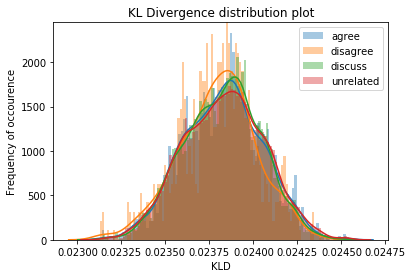

In [297]:
sns.distplot(x, bins = 100, label='agree')
sns.distplot(y, bins = 100,label='disagree')
sns.distplot(z, bins = 100,label='discuss')
sns.distplot(w, bins = 100,label='unrelated')
plt.title("KL Divergence distribution plot")
plt.xlabel("KLD")
plt.ylabel("Frequency of occourence")
plt.legend()
plt.show()

## Word frequency and probabilities

In [303]:
from collections import Counter

In [304]:
def word_list (df, col):
    i = 0
    dic = []
    for cleanList in df[col]:
        dic = dic+cleanList
        i+=1
        print(i)
    dic.sort()
    dic = [s.strip() for s in dic if len(s.strip()) != 0] 
    return dic

In [306]:
vh_words = word_list(new_val,'Clean_headline')

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


2693
2694
2695
2696
2697
2698
2699
2700
2701
2702
2703
2704
2705
2706
2707
2708
2709
2710
2711
2712
2713
2714
2715
2716
2717
2718
2719
2720
2721
2722
2723
2724
2725
2726
2727
2728
2729
2730
2731
2732
2733
2734
2735
2736
2737
2738
2739
2740
2741
2742
2743
2744
2745
2746
2747
2748
2749
2750
2751
2752
2753
2754
2755
2756
2757
2758
2759
2760
2761
2762
2763
2764
2765
2766
2767
2768
2769
2770
2771
2772
2773
2774
2775
2776
2777
2778
2779
2780
2781
2782
2783
2784
2785
2786
2787
2788
2789
2790
2791
2792
2793
2794
2795
2796
2797
2798
2799
2800
2801
2802
2803
2804
2805
2806
2807
2808
2809
2810
2811
2812
2813
2814
2815
2816
2817
2818
2819
2820
2821
2822
2823
2824
2825
2826
2827
2828
2829
2830
2831
2832
2833
2834
2835
2836
2837
2838
2839
2840
2841
2842
2843
2844
2845
2846
2847
2848
2849
2850
2851
2852
2853
2854
2855
2856
2857
2858
2859
2860
2861
2862
2863
2864
2865
2866
2867
2868
2869
2870
2871
2872
2873
2874
2875
2876
2877
2878
2879
2880
2881
2882
2883
2884
2885
2886
2887
2888
2889
2890
2891
2892


4596
4597
4598
4599
4600
4601
4602
4603
4604
4605
4606
4607
4608
4609
4610
4611
4612
4613
4614
4615
4616
4617
4618
4619
4620
4621
4622
4623
4624
4625
4626
4627
4628
4629
4630
4631
4632
4633
4634
4635
4636
4637
4638
4639
4640
4641
4642
4643
4644
4645
4646
4647
4648
4649
4650
4651
4652
4653
4654
4655
4656
4657
4658
4659
4660
4661
4662
4663
4664
4665
4666
4667
4668
4669
4670
4671
4672
4673
4674
4675
4676
4677
4678
4679
4680
4681
4682
4683
4684
4685
4686
4687
4688
4689
4690
4691
4692
4693
4694
4695
4696
4697
4698
4699
4700
4701
4702
4703
4704
4705
4706
4707
4708
4709
4710
4711
4712
4713
4714
4715
4716
4717
4718
4719
4720
4721
4722
4723
4724
4725
4726
4727
4728
4729
4730
4731
4732
4733
4734
4735
4736
4737
4738
4739
4740
4741
4742
4743
4744
4745
4746
4747
4748
4749
4750
4751
4752
4753
4754
4755
4756
4757
4758
4759
4760
4761
4762
4763
4764
4765
4766
4767
4768
4769
4770
4771
4772
4773
4774
4775
4776
4777
4778
4779
4780
4781
4782
4783
4784
4785
4786
4787
4788
4789
4790
4791
4792
4793
4794
4795


In [52]:
vb_words = word_list(val_clean,'Clean_body')

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070


3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3711
3712
3713
3714
3715
3716


In [307]:
counts_vh = Counter(vh_words)
counts_vh

Counter({'style': 2,
         'm': 34,
         'million': 62,
         'pound': 7,
         'watch': 199,
         'foot': 8,
         'foot deep': 5,
         'inch': 25,
         'k': 10,
         'karat': 5,
         'mb': 2,
         'month': 21,
         'year': 56,
         'year old': 34,
         'th': 1,
         'www ctvnews ca canada see you monday n l man keeps facebook promise to police turns himself in': 1,
         'www ctvnews ca world dog abandoned at scottish rail station with suitcase full of belongings': 5,
         'www wnd com           teen girls get pregnant on school trip': 6,
         'a': 2,
         'abort': 18,
         'about': 1,
         'abu': 40,
         'after': 3,
         'agre': 30,
         'al': 14,
         'amaz': 7,
         'american': 224,
         'arrest': 81,
         'at': 21,
         'attempt': 31,
         'back': 24,
         'ban': 12,
         'banksi': 64,
         'batman': 32,
         'beatl': 6,
         'becom': 10,
       

In [55]:
counts_vb = Counter(vb_words)
counts_vb

Counter({'plu': 118,
         'ad': 1281,
         'k': 189,
         'se': 56,
         'square foot': 7,
         'square metr': 3,
         'strong': 238,
         'km': 27,
         'mile': 273,
         'year old': 1087,
         'am': 83,
         'ft': 51,
         'i e': 23,
         'pm': 141,
         'style': 78,
         'the': 125,
         'to': 20,
         'tw': 1,
         'acr': 56,
         'billion': 120,
         'degre': 130,
         'footer': 1,
         'hp': 4,
         'liter': 80,
         'm': 348,
         'million': 789,
         'million square foot': 1,
         'oz': 13,
         'pound': 120,
         'pounder': 55,
         'rc': 115,
         'reddit': 150,
         'word': 368,
         'x': 111,
         'a year': 6,
         'appl': 3867,
         'bhp': 4,
         'build': 975,
         'but': 41,
         'date': 425,
         'day': 2142,
         'feet': 191,
         'foot': 185,
         'foot deep': 17,
         'foot long': 27,
         

In [59]:
total_vh_count = len(vh_words)
total_vh_count

42760

In [64]:
total_vb_count = len(vb_words)
total_vb_count

1100209

In [69]:
prob_vh = counts_vh
for word in counts_vh:
    prob_vh[word] = counts_vh[word] / float(total_vh_count)
prob_vh

Counter({'style': 3.8640426608345275e-17,
         'm': 6.568872523418696e-16,
         'million': 1.1978532248587035e-15,
         'pound': 1.3524149312920843e-16,
         'watch': 3.8447224475303544e-15,
         'foot': 1.545617064333811e-16,
         'foot deep': 9.660106652086318e-17,
         'inch': 4.830053326043159e-16,
         'k': 1.9320213304172636e-16,
         'karat': 9.660106652086318e-17,
         'mb': 3.8640426608345275e-17,
         'month': 4.0572447938762537e-16,
         'year': 1.0819319450336675e-15,
         'year old': 6.568872523418696e-16,
         'th': 1.9320213304172638e-17,
         'www ctvnews ca canada see you monday n l man keeps facebook promise to police turns himself in': 1.9320213304172638e-17,
         'www ctvnews ca world dog abandoned at scottish rail station with suitcase full of belongings': 9.660106652086318e-17,
         'www wnd com           teen girls get pregnant on school trip': 1.1592127982503581e-16,
         'a': 3.864042660834

In [70]:
prob_vb = counts_vb
for word in counts_vb:
    prob_vb[word] = counts_vb[word] / float(total_vb_count)
prob_vb

Counter({'plu': 0.00010725234932635526,
         'ad': 0.0011643242329411956,
         'k': 0.00017178554256509445,
         'se': 5.089942001928724e-05,
         'square foot': 6.362427502410905e-06,
         'square metr': 2.726754643890388e-06,
         'strong': 0.00021632253508197078,
         'km': 2.4540791795013492e-05,
         'mile': 0.0002481346725940253,
         'year old': 0.0009879940993029507,
         'am': 7.544021181430074e-05,
         'ft': 4.63548289461366e-05,
         'i e': 2.0905118936492976e-05,
         'pm': 0.00012815746826284823,
         'style': 7.08956207411501e-05,
         'the': 0.00011361477682876618,
         'to': 1.817836429260259e-05,
         'tw': 9.089182146301294e-07,
         'acr': 5.089942001928724e-05,
         'billion': 0.00010907018575561552,
         'degre': 0.00011815936790191682,
         'footer': 9.089182146301294e-07,
         'hp': 3.6356728585205176e-06,
         'liter': 7.271345717041035e-05,
         'm': 0.0003163035386

## Alternative model - Xgboost classsifer

In [210]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn import metrics
import time 
from xgboost import XGBClassifier
from sklearn.tree import 

In [206]:
val_features = val_LR[['cos','Man_dis','Euc_dis']]
val_y = val_LR['S']

train_features = train_LR[['cos','Man_dis','Euc_dis']]
train_y = train_LR['S']

test_features = test_LR[['cos','Man_dis','Euc_dis']]
test_y = test_LR['S']

In [267]:
#"MODEL 3 - Xgboost Classifier"

start = time.time()
clf = XGBClassifier(max_depth=3,n_estimators=100, learning_rate=0.1,gamma = 0.3,
                      min_child_weight =9,colsample_bytree=0.7,subsample=0.8)
clf.fit(train_features, train_y)
prediction3 = np.array(clf.predict(test_features))

score = accuracy_score(test_y, prediction3)
end = time.time()
    
print("MODEL 3 - Xgboost Classifier")
print("Accuracy score =", score)
print("RMSE: ", rmse(test_y, prediction3))
print("NRMSE: ",rmse(test_y, prediction3)/test_y_mean)
print("R2 Score: ", r2_score(test_y, prediction3))
print("Running time =", end - start)

MODEL 3 - Xgboost Classifier
Accuracy score = 0.814308238076
RMSE:  0.736566730101
NRMSE:  0.207793903442
R2 Score:  0.2795155207298775
Running time = 4.094158887863159


In [ ]:
print('Testing results evaluation - logistic')
print("RMSE: ", rmse(Y_t, yt_pred))
print("NRMSE: ",rmse(Y_t, yt_pred)/test_y_mean)
print("R2 Score: ", r2_score(Y_t, yt_pred))